In [1]:
# importamos simpy
import simpy
# importamos random
import random
# importamos pandas
import pandas as pd
# importamos pyplot
from matplotlib import pyplot as plt

# Simulaciones con intervalo de 10

# Simulación con 25 Procesos e intervalo 10

In [2]:
# creamos una lista para guardar las horas de llegada al estado waiting de cada programa
horas_llegada = []
# creamos una lista para guardar las horas en que termina el proceso para cada programa
horas_terminado = []

In [3]:
# Creamos las variables a utilizar
RANDOM_SEED = 42
PROCESOS = 25  # Número de procesos
INTERVAL = 10  # Definido para el problema 
MEMORIA = 100 # Cpacidad de memoria de la RAM
CAPACIDAD = 1 # Capacidad de CPU 
INSTRUCCIONES_POR_TIEMPO = 3 # Instrucciones en el CPU 

In [4]:
# Definimos una clase para el proceso que al final es un programa que entra al sistema
class Programa:
    def __init__(self, env, nombre, memoria, instrucciones):
        self.env = env
        self.memoria = memoria
        self.nombre = nombre
        self.instrucciones = instrucciones
        self.estado = 'new'
        self.tiempo_espera = 0
        self.tiempo_cpu = 0
    

# Definimos los procesos tanto sus instrucciones como el espacio de memoria que se generara
def procesador(env, memoria_ram):
    while True:
        for i in range(PROCESOS):
            # damos un tiempo random antes de llegar al cpu 
            yield env.timeout(random.expovariate(1/INTERVAL)) #Para retonar consecutivamente valores
            # generamos el espacio en la memoria  ram que tomará el proceso
            memoria = random.randint(1,10)
            nombre = i
            # generamos la cantidad de instrucciones totales a realizar por el process 
            instrucciones = random.randint(1,10)
            print('El proceso %g tiene un espacio de memoria de %f y tiene %d instrucciones'%(nombre, memoria,instrucciones))
            # Iniciamos a generar procesos
            proceso = Programa(env, nombre, memoria, instrucciones)
            env.process(ingreso(env, proceso, memoria_ram))

# Se ingresa el proceso al sistema de new, ready y el paso al CPU
def ingreso(env, process, memoria_ram):
    # El proceso inicia como nuevo
    
    print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
    with memoria_ram.get(process.memoria):
        yield memoria_ram.get(process.memoria)
        process.estado = 'ready'
        process.estado = 'new'
        
        # Cuando el proceso es nuevo pasa al estado ready para colocarse en el CPU
        print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
        env.process(cpu_proceso(env, process))
    # Si el proceso termina satisfactoriamente en el cpu el estado es terminado y se devulve la memoria
    memoria_ram.put(process.memoria)
    process.estado = 'terminated'

# Se define el funcionamiento del proceso del CPU
def cpu_proceso(env, process):
    with cpu.request() as req:
        hora_llegada = env.now
        horas_llegada.append(hora_llegada)
        yield req
        # Si el proceso pasa el CPU cambia de estado a running
        process.estado = 'running'
        print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g'%(env.now))
        while process.instrucciones > 0:
            # Solo se pueden ejecutar 3 instrucciones por tiempo
            yield env.timeout(1)
            process.instrucciones -= INSTRUCCIONES_POR_TIEMPO
            process.tiempo_cpu += 1
            if process.instrucciones <= 0:
                break
            if process.tiempo_cpu % 3 == 0:
                # El proceso al terminarse puede ir a waiting o procesos de I/O según el número generado al azar
                if random.randint(1, 2) == 1:
                    process.estado = 'waiting'
                    print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
                    env.process(io_proceso(env, process))
                    yield env.timeout(1)
                    process.tiempo_espera += 1
                else:
                    process.estado = 'ready'
                    print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
                    env.process(cpu_proceso(env, process))
        process.estado = 'terminated'
        print('El proceso %g termino con exito '%(process.nombre) + ' a las %g'%(env.now))
        hora_terminado = env.now
        horas_terminado.append(hora_terminado)
        
        
# Definimos el procedimiento para las operaciones de I/O
def io_proceso(env, process):
    # El proceso entra en las operaciones I/O y al finalizar pasa a estado ready
    print('El proceso %g entro a los procesos I/O '%(process.nombre)+' a las %g'%(env.now))
    yield env.timeout(random.randint(1, 2))
    process.estado = 'ready'
    print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
    env.process(cpu_proceso(env, process))

In [5]:
# creamos el ambiente 
env = simpy.Environment()
random.seed(RANDOM_SEED)
cpu = simpy.Resource(env, capacity = CAPACIDAD)
memoria_ram = simpy.Container(env, init = MEMORIA , capacity= MEMORIA)
env.process(procesador(env, memoria_ram )) 
# nota: quite el procesos
env.run(until= 500)

El proceso 0 tiene un espacio de memoria de 1.000000 y tiene 5 instrucciones
El estado del proceso 0 es new a las 10.2006 
El estado del proceso 0 es new a las 10.2006 
El estado del proceso 0 es running a las 10.2006
El proceso 0 termino con exito  a las 12.2006
El proceso 1 tiene un espacio de memoria de 3.000000 y tiene 2 instrucciones
El estado del proceso 1 es new a las 13.0095 
El estado del proceso 1 es new a las 13.0095 
El estado del proceso 1 es running a las 13.0095
El proceso 1 termino con exito  a las 14.0095
El proceso 2 tiene un espacio de memoria de 9.000000 y tiene 2 instrucciones
El estado del proceso 2 es new a las 24.3013 
El estado del proceso 2 es new a las 24.3013 
El estado del proceso 2 es running a las 24.3013
El proceso 2 termino con exito  a las 25.3013
El proceso 3 tiene un espacio de memoria de 1.000000 y tiene 1 instrucciones
El estado del proceso 3 es new a las 33.2293 
El estado del proceso 3 es new a las 33.2293 
El estado del proceso 3 es running a la

In [6]:
len(horas_terminado)

15

In [7]:
len(horas_llegada)

15

In [8]:
# restamos las horas de terminacion de los procesos con las horas de inicio
tiempos = []

for item1, item2 in zip(horas_terminado, horas_llegada):
    tiempos.append(item1-item2)

In [9]:
# creamos un DataFrame en el cual guardaremos los tiempos de las simulaciones
dataframe = pd.DataFrame()

In [10]:
# guardamos los tiempos de la simulacion en la columna respectiva del dataframe
dataframe["25 procesos"] = tiempos

# Segunda Simulación con 50 procesos

In [11]:
# creamos una lista para guardar las horas de llegada al estado waiting de cada programa
horas_llegada = []
# creamos una lista para guardar las horas en que termina el proceso para cada programa
horas_terminado = []

In [12]:
# Creamos las variables a utilizar
RANDOM_SEED = 42
PROCESOS = 50  # Número de procesos
INTERVAL = 10  # Definido para el problema 
MEMORIA = 100 # Cpacidad de memoria de la RAM
CAPACIDAD = 1 # Capacidad de CPU 
INSTRUCCIONES_POR_TIEMPO = 3 # Instrucciones en el CPU 

In [13]:
# Definimos una clase para el proceso que al final es un programa que entra al sistema
class Programa:
    def __init__(self, env, nombre, memoria, instrucciones):
        self.env = env
        self.memoria = memoria
        self.nombre = nombre
        self.instrucciones = instrucciones
        self.estado = 'new'
        self.tiempo_espera = 0
        self.tiempo_cpu = 0
    

# Definimos los procesos tanto sus instrucciones como el espacio de memoria que se generara
def procesador(env, memoria_ram):
    while True:
        for i in range(PROCESOS):
            # damos un tiempo random antes de llegar al cpu 
            yield env.timeout(random.expovariate(1/INTERVAL)) #Para retonar consecutivamente valores
            # generamos el espacio en la memoria  ram que tomará el proceso
            memoria = random.randint(1,10)
            nombre = i
            # generamos la cantidad de instrucciones totales a realizar por el process 
            instrucciones = random.randint(1,10)
            print('El proceso %g tiene un espacio de memoria de %f y tiene %d instrucciones'%(nombre, memoria,instrucciones))
            # Iniciamos a generar procesos
            proceso = Programa(env, nombre, memoria, instrucciones)
            env.process(ingreso(env, proceso, memoria_ram))

# Se ingresa el proceso al sistema de new, ready y el paso al CPU
def ingreso(env, process, memoria_ram):
    # El proceso inicia como nuevo
    
    print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
    with memoria_ram.get(process.memoria):
        yield memoria_ram.get(process.memoria)
        process.estado = 'ready'
        process.estado = 'new'
        
        # Cuando el proceso es nuevo pasa al estado ready para colocarse en el CPU
        print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
        env.process(cpu_proceso(env, process))
    # Si el proceso termina satisfactoriamente en el cpu el estado es terminado y se devulve la memoria
    memoria_ram.put(process.memoria)
    process.estado = 'terminated'

# Se define el funcionamiento del proceso del CPU
def cpu_proceso(env, process):
    with cpu.request() as req:
        hora_llegada = env.now
        horas_llegada.append(hora_llegada)
        yield req
        # Si el proceso pasa el CPU cambia de estado a running
        process.estado = 'running'
        print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g'%(env.now))
        while process.instrucciones > 0:
            # Solo se pueden ejecutar 3 instrucciones por tiempo
            yield env.timeout(1)
            process.instrucciones -= INSTRUCCIONES_POR_TIEMPO
            process.tiempo_cpu += 1
            if process.instrucciones <= 0:
                break
            if process.tiempo_cpu % 3 == 0:
                # El proceso al terminarse puede ir a waiting o procesos de I/O según el número generado al azar
                if random.randint(1, 2) == 1:
                    process.estado = 'waiting'
                    print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
                    env.process(io_proceso(env, process))
                    yield env.timeout(1)
                    process.tiempo_espera += 1
                else:
                    process.estado = 'ready'
                    print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
                    env.process(cpu_proceso(env, process))
        process.estado = 'terminated'
        print('El proceso %g termino con exito '%(process.nombre) + ' a las %g'%(env.now))
        hora_terminado = env.now
        horas_terminado.append(hora_terminado)
        
        
# Definimos el procedimiento para las operaciones de I/O
def io_proceso(env, process):
    # El proceso entra en las operaciones I/O y al finalizar pasa a estado ready
    print('El proceso %g entro a los procesos I/O '%(process.nombre)+' a las %g'%(env.now))
    yield env.timeout(random.randint(1, 2))
    process.estado = 'ready'
    print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
    env.process(cpu_proceso(env, process))

In [14]:
# creamos el ambiente 
env = simpy.Environment()
random.seed(RANDOM_SEED)
cpu = simpy.Resource(env, capacity = CAPACIDAD)
memoria_ram = simpy.Container(env, init = MEMORIA , capacity= MEMORIA)
env.process(procesador(env, memoria_ram )) 
# nota: quite el procesos
env.run(until= 500)

El proceso 0 tiene un espacio de memoria de 1.000000 y tiene 5 instrucciones
El estado del proceso 0 es new a las 10.2006 
El estado del proceso 0 es new a las 10.2006 
El estado del proceso 0 es running a las 10.2006
El proceso 0 termino con exito  a las 12.2006
El proceso 1 tiene un espacio de memoria de 3.000000 y tiene 2 instrucciones
El estado del proceso 1 es new a las 13.0095 
El estado del proceso 1 es new a las 13.0095 
El estado del proceso 1 es running a las 13.0095
El proceso 1 termino con exito  a las 14.0095
El proceso 2 tiene un espacio de memoria de 9.000000 y tiene 2 instrucciones
El estado del proceso 2 es new a las 24.3013 
El estado del proceso 2 es new a las 24.3013 
El estado del proceso 2 es running a las 24.3013
El proceso 2 termino con exito  a las 25.3013
El proceso 3 tiene un espacio de memoria de 1.000000 y tiene 1 instrucciones
El estado del proceso 3 es new a las 33.2293 
El estado del proceso 3 es new a las 33.2293 
El estado del proceso 3 es running a la

In [15]:
len(horas_terminado)

15

In [16]:
len(horas_llegada)

15

In [17]:
# restamos las horas de terminacion de los procesos con las horas de inicio
tiempos = []

for item1, item2 in zip(horas_terminado, horas_llegada):
    tiempos.append(item1-item2)

In [18]:
# guardamos los tiempos de la simulacion en la columna respectiva del dataframe
dataframe["50 procesos"] = tiempos

# Simulación con 100 Procesos

In [19]:
# creamos una lista para guardar las horas de llegada al estado waiting de cada programa
horas_llegada = []
# creamos una lista para guardar las horas en que termina el proceso para cada programa
horas_terminado = []

In [20]:
# Creamos las variables a utilizar
RANDOM_SEED = 42
PROCESOS = 100  # Número de procesos
INTERVAL = 10  # Definido para el problema 
MEMORIA = 100 # Cpacidad de memoria de la RAM
CAPACIDAD = 1 # Capacidad de CPU 
INSTRUCCIONES_POR_TIEMPO = 3 # Instrucciones en el CPU 

In [21]:
# Definimos una clase para el proceso que al final es un programa que entra al sistema
class Programa:
    def __init__(self, env, nombre, memoria, instrucciones):
        self.env = env
        self.memoria = memoria
        self.nombre = nombre
        self.instrucciones = instrucciones
        self.estado = 'new'
        self.tiempo_espera = 0
        self.tiempo_cpu = 0
    

# Definimos los procesos tanto sus instrucciones como el espacio de memoria que se generara
def procesador(env, memoria_ram):
    while True:
        for i in range(PROCESOS):
            # damos un tiempo random antes de llegar al cpu 
            yield env.timeout(random.expovariate(1/INTERVAL)) #Para retonar consecutivamente valores
            # generamos el espacio en la memoria  ram que tomará el proceso
            memoria = random.randint(1,10)
            nombre = i
            # generamos la cantidad de instrucciones totales a realizar por el process 
            instrucciones = random.randint(1,10)
            print('El proceso %g tiene un espacio de memoria de %f y tiene %d instrucciones'%(nombre, memoria,instrucciones))
            # Iniciamos a generar procesos
            proceso = Programa(env, nombre, memoria, instrucciones)
            env.process(ingreso(env, proceso, memoria_ram))

# Se ingresa el proceso al sistema de new, ready y el paso al CPU
def ingreso(env, process, memoria_ram):
    # El proceso inicia como nuevo
    
    print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
    with memoria_ram.get(process.memoria):
        yield memoria_ram.get(process.memoria)
        process.estado = 'ready'
        process.estado = 'new'
        
        # Cuando el proceso es nuevo pasa al estado ready para colocarse en el CPU
        print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
        env.process(cpu_proceso(env, process))
    # Si el proceso termina satisfactoriamente en el cpu el estado es terminado y se devulve la memoria
    memoria_ram.put(process.memoria)
    process.estado = 'terminated'

# Se define el funcionamiento del proceso del CPU
def cpu_proceso(env, process):
    with cpu.request() as req:
        hora_llegada = env.now
        horas_llegada.append(hora_llegada)
        yield req
        # Si el proceso pasa el CPU cambia de estado a running
        process.estado = 'running'
        print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g'%(env.now))
        while process.instrucciones > 0:
            # Solo se pueden ejecutar 3 instrucciones por tiempo
            yield env.timeout(1)
            process.instrucciones -= INSTRUCCIONES_POR_TIEMPO
            process.tiempo_cpu += 1
            if process.instrucciones <= 0:
                break
            if process.tiempo_cpu % 3 == 0:
                # El proceso al terminarse puede ir a waiting o procesos de I/O según el número generado al azar
                if random.randint(1, 2) == 1:
                    process.estado = 'waiting'
                    print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
                    env.process(io_proceso(env, process))
                    yield env.timeout(1)
                    process.tiempo_espera += 1
                else:
                    process.estado = 'ready'
                    print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
                    env.process(cpu_proceso(env, process))
        process.estado = 'terminated'
        print('El proceso %g termino con exito '%(process.nombre) + ' a las %g'%(env.now))
        hora_terminado = env.now
        horas_terminado.append(hora_terminado)
        
        
# Definimos el procedimiento para las operaciones de I/O
def io_proceso(env, process):
    # El proceso entra en las operaciones I/O y al finalizar pasa a estado ready
    print('El proceso %g entro a los procesos I/O '%(process.nombre)+' a las %g'%(env.now))
    yield env.timeout(random.randint(1, 2))
    process.estado = 'ready'
    print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
    env.process(cpu_proceso(env, process))

In [22]:
# creamos el ambiente 
env = simpy.Environment()
random.seed(RANDOM_SEED)
cpu = simpy.Resource(env, capacity = CAPACIDAD)
memoria_ram = simpy.Container(env, init = MEMORIA , capacity= MEMORIA)
env.process(procesador(env, memoria_ram )) 
# nota: quite el procesos
env.run(until= 500)

El proceso 0 tiene un espacio de memoria de 1.000000 y tiene 5 instrucciones
El estado del proceso 0 es new a las 10.2006 
El estado del proceso 0 es new a las 10.2006 
El estado del proceso 0 es running a las 10.2006
El proceso 0 termino con exito  a las 12.2006
El proceso 1 tiene un espacio de memoria de 3.000000 y tiene 2 instrucciones
El estado del proceso 1 es new a las 13.0095 
El estado del proceso 1 es new a las 13.0095 
El estado del proceso 1 es running a las 13.0095
El proceso 1 termino con exito  a las 14.0095
El proceso 2 tiene un espacio de memoria de 9.000000 y tiene 2 instrucciones
El estado del proceso 2 es new a las 24.3013 
El estado del proceso 2 es new a las 24.3013 
El estado del proceso 2 es running a las 24.3013
El proceso 2 termino con exito  a las 25.3013
El proceso 3 tiene un espacio de memoria de 1.000000 y tiene 1 instrucciones
El estado del proceso 3 es new a las 33.2293 
El estado del proceso 3 es new a las 33.2293 
El estado del proceso 3 es running a la

In [23]:
# restamos las horas de terminacion de los procesos con las horas de inicio
tiempos = []

for item1, item2 in zip(horas_terminado, horas_llegada):
    tiempos.append(item1-item2)

In [24]:
# guardamos los tiempos de la simulacion en la columna respectiva del dataframe
dataframe["100 procesos"] = tiempos

# Simulación con 150 Procesos

In [25]:
# creamos una lista para guardar las horas de llegada al estado waiting de cada programa
horas_llegada = []
# creamos una lista para guardar las horas en que termina el proceso para cada programa
horas_terminado = []

In [26]:
# Creamos las variables a utilizar
RANDOM_SEED = 42
PROCESOS = 150  # Número de procesos
INTERVAL = 10  # Definido para el problema 
MEMORIA = 100 # Cpacidad de memoria de la RAM
CAPACIDAD = 1 # Capacidad de CPU 
INSTRUCCIONES_POR_TIEMPO = 3 # Instrucciones en el CPU 

In [27]:
# Definimos una clase para el proceso que al final es un programa que entra al sistema
class Programa:
    def __init__(self, env, nombre, memoria, instrucciones):
        self.env = env
        self.memoria = memoria
        self.nombre = nombre
        self.instrucciones = instrucciones
        self.estado = 'new'
        self.tiempo_espera = 0
        self.tiempo_cpu = 0
    

# Definimos los procesos tanto sus instrucciones como el espacio de memoria que se generara
def procesador(env, memoria_ram):
    while True:
        for i in range(PROCESOS):
            # damos un tiempo random antes de llegar al cpu 
            yield env.timeout(random.expovariate(1/INTERVAL)) #Para retonar consecutivamente valores
            # generamos el espacio en la memoria  ram que tomará el proceso
            memoria = random.randint(1,10)
            nombre = i
            # generamos la cantidad de instrucciones totales a realizar por el process 
            instrucciones = random.randint(1,10)
            print('El proceso %g tiene un espacio de memoria de %f y tiene %d instrucciones'%(nombre, memoria,instrucciones))
            # Iniciamos a generar procesos
            proceso = Programa(env, nombre, memoria, instrucciones)
            env.process(ingreso(env, proceso, memoria_ram))

# Se ingresa el proceso al sistema de new, ready y el paso al CPU
def ingreso(env, process, memoria_ram):
    # El proceso inicia como nuevo
    
    print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
    with memoria_ram.get(process.memoria):
        yield memoria_ram.get(process.memoria)
        process.estado = 'ready'
        process.estado = 'new'
        
        # Cuando el proceso es nuevo pasa al estado ready para colocarse en el CPU
        print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
        env.process(cpu_proceso(env, process))
    # Si el proceso termina satisfactoriamente en el cpu el estado es terminado y se devulve la memoria
    memoria_ram.put(process.memoria)
    process.estado = 'terminated'

# Se define el funcionamiento del proceso del CPU
def cpu_proceso(env, process):
    with cpu.request() as req:
        hora_llegada = env.now
        horas_llegada.append(hora_llegada)
        yield req
        # Si el proceso pasa el CPU cambia de estado a running
        process.estado = 'running'
        print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g'%(env.now))
        while process.instrucciones > 0:
            # Solo se pueden ejecutar 3 instrucciones por tiempo
            yield env.timeout(1)
            process.instrucciones -= INSTRUCCIONES_POR_TIEMPO
            process.tiempo_cpu += 1
            if process.instrucciones <= 0:
                break
            if process.tiempo_cpu % 3 == 0:
                # El proceso al terminarse puede ir a waiting o procesos de I/O según el número generado al azar
                if random.randint(1, 2) == 1:
                    process.estado = 'waiting'
                    print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
                    env.process(io_proceso(env, process))
                    yield env.timeout(1)
                    process.tiempo_espera += 1
                else:
                    process.estado = 'ready'
                    print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
                    env.process(cpu_proceso(env, process))
        process.estado = 'terminated'
        print('El proceso %g termino con exito '%(process.nombre) + ' a las %g'%(env.now))
        hora_terminado = env.now
        horas_terminado.append(hora_terminado)
        
        
# Definimos el procedimiento para las operaciones de I/O
def io_proceso(env, process):
    # El proceso entra en las operaciones I/O y al finalizar pasa a estado ready
    print('El proceso %g entro a los procesos I/O '%(process.nombre)+' a las %g'%(env.now))
    yield env.timeout(random.randint(1, 2))
    process.estado = 'ready'
    print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
    env.process(cpu_proceso(env, process))

In [28]:
# creamos el ambiente 
env = simpy.Environment()
random.seed(RANDOM_SEED)
cpu = simpy.Resource(env, capacity = CAPACIDAD)
memoria_ram = simpy.Container(env, init = MEMORIA , capacity= MEMORIA)
env.process(procesador(env, memoria_ram )) 
# nota: quite el procesos
env.run(until= 500)

El proceso 0 tiene un espacio de memoria de 1.000000 y tiene 5 instrucciones
El estado del proceso 0 es new a las 10.2006 
El estado del proceso 0 es new a las 10.2006 
El estado del proceso 0 es running a las 10.2006
El proceso 0 termino con exito  a las 12.2006
El proceso 1 tiene un espacio de memoria de 3.000000 y tiene 2 instrucciones
El estado del proceso 1 es new a las 13.0095 
El estado del proceso 1 es new a las 13.0095 
El estado del proceso 1 es running a las 13.0095
El proceso 1 termino con exito  a las 14.0095
El proceso 2 tiene un espacio de memoria de 9.000000 y tiene 2 instrucciones
El estado del proceso 2 es new a las 24.3013 
El estado del proceso 2 es new a las 24.3013 
El estado del proceso 2 es running a las 24.3013
El proceso 2 termino con exito  a las 25.3013
El proceso 3 tiene un espacio de memoria de 1.000000 y tiene 1 instrucciones
El estado del proceso 3 es new a las 33.2293 
El estado del proceso 3 es new a las 33.2293 
El estado del proceso 3 es running a la

In [29]:
# restamos las horas de terminacion de los procesos con las horas de inicio
tiempos = []

for item1, item2 in zip(horas_terminado, horas_llegada):
    tiempos.append(item1-item2)

In [30]:
# guardamos los tiempos de la simulacion en la columna respectiva del dataframe
dataframe["150 procesos"] = tiempos

# Simulación con 200 Procesos

In [31]:
# creamos una lista para guardar las horas de llegada al estado waiting de cada programa
horas_llegada = []
# creamos una lista para guardar las horas en que termina el proceso para cada programa
horas_terminado = []

In [32]:
# Creamos las variables a utilizar
RANDOM_SEED = 42
PROCESOS = 200  # Número de procesos
INTERVAL = 10  # Definido para el problema 
MEMORIA = 100 # Cpacidad de memoria de la RAM
CAPACIDAD = 1 # Capacidad de CPU 
INSTRUCCIONES_POR_TIEMPO = 3 # Instrucciones en el CPU 

In [33]:
# Definimos una clase para el proceso que al final es un programa que entra al sistema
class Programa:
    def __init__(self, env, nombre, memoria, instrucciones):
        self.env = env
        self.memoria = memoria
        self.nombre = nombre
        self.instrucciones = instrucciones
        self.estado = 'new'
        self.tiempo_espera = 0
        self.tiempo_cpu = 0
    

# Definimos los procesos tanto sus instrucciones como el espacio de memoria que se generara
def procesador(env, memoria_ram):
    while True:
        for i in range(PROCESOS):
            # damos un tiempo random antes de llegar al cpu 
            yield env.timeout(random.expovariate(1/INTERVAL)) #Para retonar consecutivamente valores
            # generamos el espacio en la memoria  ram que tomará el proceso
            memoria = random.randint(1,10)
            nombre = i
            # generamos la cantidad de instrucciones totales a realizar por el process 
            instrucciones = random.randint(1,10)
            print('El proceso %g tiene un espacio de memoria de %f y tiene %d instrucciones'%(nombre, memoria,instrucciones))
            # Iniciamos a generar procesos
            proceso = Programa(env, nombre, memoria, instrucciones)
            env.process(ingreso(env, proceso, memoria_ram))

# Se ingresa el proceso al sistema de new, ready y el paso al CPU
def ingreso(env, process, memoria_ram):
    # El proceso inicia como nuevo
    
    print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
    with memoria_ram.get(process.memoria):
        yield memoria_ram.get(process.memoria)
        process.estado = 'ready'
        process.estado = 'new'
        
        # Cuando el proceso es nuevo pasa al estado ready para colocarse en el CPU
        print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
        env.process(cpu_proceso(env, process))
    # Si el proceso termina satisfactoriamente en el cpu el estado es terminado y se devulve la memoria
    memoria_ram.put(process.memoria)
    process.estado = 'terminated'

# Se define el funcionamiento del proceso del CPU
def cpu_proceso(env, process):
    with cpu.request() as req:
        hora_llegada = env.now
        horas_llegada.append(hora_llegada)
        yield req
        # Si el proceso pasa el CPU cambia de estado a running
        process.estado = 'running'
        print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g'%(env.now))
        while process.instrucciones > 0:
            # Solo se pueden ejecutar 3 instrucciones por tiempo
            yield env.timeout(1)
            process.instrucciones -= INSTRUCCIONES_POR_TIEMPO
            process.tiempo_cpu += 1
            if process.instrucciones <= 0:
                break
            if process.tiempo_cpu % 3 == 0:
                # El proceso al terminarse puede ir a waiting o procesos de I/O según el número generado al azar
                if random.randint(1, 2) == 1:
                    process.estado = 'waiting'
                    print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
                    env.process(io_proceso(env, process))
                    yield env.timeout(1)
                    process.tiempo_espera += 1
                else:
                    process.estado = 'ready'
                    print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
                    env.process(cpu_proceso(env, process))
        process.estado = 'terminated'
        print('El proceso %g termino con exito '%(process.nombre) + ' a las %g'%(env.now))
        hora_terminado = env.now
        horas_terminado.append(hora_terminado)
        
        
# Definimos el procedimiento para las operaciones de I/O
def io_proceso(env, process):
    # El proceso entra en las operaciones I/O y al finalizar pasa a estado ready
    print('El proceso %g entro a los procesos I/O '%(process.nombre)+' a las %g'%(env.now))
    yield env.timeout(random.randint(1, 2))
    process.estado = 'ready'
    print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
    env.process(cpu_proceso(env, process))

In [34]:
# creamos el ambiente 
env = simpy.Environment()
random.seed(RANDOM_SEED)
cpu = simpy.Resource(env, capacity = CAPACIDAD)
memoria_ram = simpy.Container(env, init = MEMORIA , capacity= MEMORIA)
env.process(procesador(env, memoria_ram )) 
# nota: quite el procesos
env.run(until= 500)

El proceso 0 tiene un espacio de memoria de 1.000000 y tiene 5 instrucciones
El estado del proceso 0 es new a las 10.2006 
El estado del proceso 0 es new a las 10.2006 
El estado del proceso 0 es running a las 10.2006
El proceso 0 termino con exito  a las 12.2006
El proceso 1 tiene un espacio de memoria de 3.000000 y tiene 2 instrucciones
El estado del proceso 1 es new a las 13.0095 
El estado del proceso 1 es new a las 13.0095 
El estado del proceso 1 es running a las 13.0095
El proceso 1 termino con exito  a las 14.0095
El proceso 2 tiene un espacio de memoria de 9.000000 y tiene 2 instrucciones
El estado del proceso 2 es new a las 24.3013 
El estado del proceso 2 es new a las 24.3013 
El estado del proceso 2 es running a las 24.3013
El proceso 2 termino con exito  a las 25.3013
El proceso 3 tiene un espacio de memoria de 1.000000 y tiene 1 instrucciones
El estado del proceso 3 es new a las 33.2293 
El estado del proceso 3 es new a las 33.2293 
El estado del proceso 3 es running a la

In [35]:
# restamos las horas de terminacion de los procesos con las horas de inicio
tiempos = []

for item1, item2 in zip(horas_terminado, horas_llegada):
    tiempos.append(item1-item2)

In [36]:
# guardamos los tiempos de la simulacion en la columna respectiva del dataframe
dataframe["200 procesos"] = tiempos

# Gráficos de media y desviación estándar

In [37]:
# visualizamos el dataframe
dataframe

,25 procesos,50 procesos,100 procesos,150 procesos,200 procesos
0,2.000000,2.000000,2.000000,2.000000,2.000000
1,1.000000,1.000000,1.000000,1.000000,1.000000
2,1.000000,1.000000,1.000000,1.000000,1.000000
3,1.000000,1.000000,1.000000,1.000000,1.000000
4,3.016204,3.016204,3.016204,3.016204,3.016204
5,2.000000,2.000000,2.000000,2.000000,2.000000
6,3.000000,3.000000,3.000000,3.000000,3.000000
7,2.509736,2.509736,2.509736,2.509736,2.509736
8,1.000000,1.000000,1.000000,1.000000,1.000000
9,2.000000,2.000000,2.000000,2.000000,2.000000


In [38]:
# creamos una lista con los promedios 
promedios = []

# calculamos los promedios de cada columna del dataframe
for column in dataframe:
    promedios.append(dataframe[column].mean())

In [39]:
# creamos una lista para guardar las desviaciones estandar
desvest = []

# calculamos los promedios de cada columna del dataframe
for column in dataframe:
    desvest.append(dataframe[column].std())

Text(0.5, 1.0, 'Promedio de tiempo y desviación est. con intervalo 10')

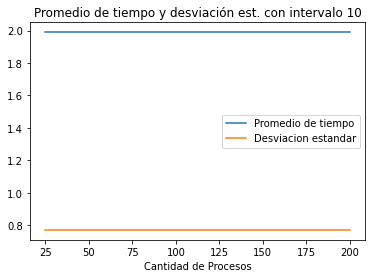

In [40]:
plt.plot([25,50,100,150,200],promedios, label = "Promedio de tiempo")
plt.plot([25,50,100,150,200],desvest, label = "Desviacion estandar")
plt.xlabel("Cantidad de Procesos")
plt.legend()
plt.title("Promedio de tiempo y desviación est. con intervalo 10")


# Simulaciones con intervalos de 5

# Simulación con 25 procesos e intervalo de 5

In [41]:
# creamos una lista para guardar las horas de llegada al estado waiting de cada programa
horas_llegada = []
# creamos una lista para guardar las horas en que termina el proceso para cada programa
horas_terminado = []

In [42]:
# Creamos las variables a utilizar
RANDOM_SEED = 42
PROCESOS = 25  # Número de procesos
INTERVAL = 5  # Definido para el problema 
MEMORIA = 100 # Cpacidad de memoria de la RAM
CAPACIDAD = 1 # Capacidad de CPU 
INSTRUCCIONES_POR_TIEMPO = 3 # Instrucciones en el CPU 

In [43]:
# Definimos una clase para el proceso que al final es un programa que entra al sistema
class Programa:
    def __init__(self, env, nombre, memoria, instrucciones):
        self.env = env
        self.memoria = memoria
        self.nombre = nombre
        self.instrucciones = instrucciones
        self.estado = 'new'
        self.tiempo_espera = 0
        self.tiempo_cpu = 0
    

# Definimos los procesos tanto sus instrucciones como el espacio de memoria que se generara
def procesador(env, memoria_ram):
    while True:
        for i in range(PROCESOS):
            # damos un tiempo random antes de llegar al cpu 
            yield env.timeout(random.expovariate(1/INTERVAL)) #Para retonar consecutivamente valores
            # generamos el espacio en la memoria  ram que tomará el proceso
            memoria = random.randint(1,10)
            nombre = i
            # generamos la cantidad de instrucciones totales a realizar por el process 
            instrucciones = random.randint(1,10)
            print('El proceso %g tiene un espacio de memoria de %f y tiene %d instrucciones'%(nombre, memoria,instrucciones))
            # Iniciamos a generar procesos
            proceso = Programa(env, nombre, memoria, instrucciones)
            env.process(ingreso(env, proceso, memoria_ram))

# Se ingresa el proceso al sistema de new, ready y el paso al CPU
def ingreso(env, process, memoria_ram):
    # El proceso inicia como nuevo
    
    print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
    with memoria_ram.get(process.memoria):
        yield memoria_ram.get(process.memoria)
        process.estado = 'ready'
        process.estado = 'new'
        
        # Cuando el proceso es nuevo pasa al estado ready para colocarse en el CPU
        print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
        env.process(cpu_proceso(env, process))
    # Si el proceso termina satisfactoriamente en el cpu el estado es terminado y se devulve la memoria
    memoria_ram.put(process.memoria)
    process.estado = 'terminated'

# Se define el funcionamiento del proceso del CPU
def cpu_proceso(env, process):
    with cpu.request() as req:
        hora_llegada = env.now
        horas_llegada.append(hora_llegada)
        yield req
        # Si el proceso pasa el CPU cambia de estado a running
        process.estado = 'running'
        print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g'%(env.now))
        while process.instrucciones > 0:
            # Solo se pueden ejecutar 3 instrucciones por tiempo
            yield env.timeout(1)
            process.instrucciones -= INSTRUCCIONES_POR_TIEMPO
            process.tiempo_cpu += 1
            if process.instrucciones <= 0:
                break
            if process.tiempo_cpu % 3 == 0:
                # El proceso al terminarse puede ir a waiting o procesos de I/O según el número generado al azar
                if random.randint(1, 2) == 1:
                    process.estado = 'waiting'
                    print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
                    env.process(io_proceso(env, process))
                    yield env.timeout(1)
                    process.tiempo_espera += 1
                else:
                    process.estado = 'ready'
                    print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
                    env.process(cpu_proceso(env, process))
        process.estado = 'terminated'
        print('El proceso %g termino con exito '%(process.nombre) + ' a las %g'%(env.now))
        hora_terminado = env.now
        horas_terminado.append(hora_terminado)
        
        
# Definimos el procedimiento para las operaciones de I/O
def io_proceso(env, process):
    # El proceso entra en las operaciones I/O y al finalizar pasa a estado ready
    print('El proceso %g entro a los procesos I/O '%(process.nombre)+' a las %g'%(env.now))
    yield env.timeout(random.randint(1, 2))
    process.estado = 'ready'
    print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
    env.process(cpu_proceso(env, process))

In [44]:
# creamos el ambiente 
env = simpy.Environment()
random.seed(RANDOM_SEED)
cpu = simpy.Resource(env, capacity = CAPACIDAD)
memoria_ram = simpy.Container(env, init = MEMORIA , capacity= MEMORIA)
env.process(procesador(env, memoria_ram )) 
# nota: quite el procesos
env.run(until= 500)

El proceso 0 tiene un espacio de memoria de 1.000000 y tiene 5 instrucciones
El estado del proceso 0 es new a las 5.1003 
El estado del proceso 0 es new a las 5.1003 
El estado del proceso 0 es running a las 5.1003
El proceso 1 tiene un espacio de memoria de 3.000000 y tiene 2 instrucciones
El estado del proceso 1 es new a las 6.50477 
El estado del proceso 1 es new a las 6.50477 
El proceso 0 termino con exito  a las 7.1003
El estado del proceso 1 es running a las 7.1003
El proceso 1 termino con exito  a las 8.1003
El proceso 2 tiene un espacio de memoria de 9.000000 y tiene 2 instrucciones
El estado del proceso 2 es new a las 12.1506 
El estado del proceso 2 es new a las 12.1506 
El estado del proceso 2 es running a las 12.1506
El proceso 2 termino con exito  a las 13.1506
El proceso 3 tiene un espacio de memoria de 1.000000 y tiene 1 instrucciones
El estado del proceso 3 es new a las 16.6146 
El estado del proceso 3 es new a las 16.6146 
El estado del proceso 3 es running a las 16.6

In [45]:
# restamos las horas de terminacion de los procesos con las horas de inicio
tiempos = []

for item1, item2 in zip(horas_terminado, horas_llegada):
    tiempos.append(item1-item2)

In [46]:
# creamos un DataFrame en el cual guardaremos los tiempos de las simulaciones
dataframe = pd.DataFrame()

In [47]:
# guardamos los tiempos de la simulacion en la columna respectiva del dataframe
dataframe["25 procesos"] = tiempos

# 50 procesos e intervalo 5

In [48]:
# creamos una lista para guardar las horas de llegada al estado waiting de cada programa
horas_llegada = []
# creamos una lista para guardar las horas en que termina el proceso para cada programa
horas_terminado = []

In [49]:
# Creamos las variables a utilizar
RANDOM_SEED = 42
PROCESOS = 50  # Número de procesos
INTERVAL = 5  # Definido para el problema 
MEMORIA = 100 # Cpacidad de memoria de la RAM
CAPACIDAD = 1 # Capacidad de CPU 
INSTRUCCIONES_POR_TIEMPO = 3 # Instrucciones en el CPU 

In [50]:
# Definimos una clase para el proceso que al final es un programa que entra al sistema
class Programa:
    def __init__(self, env, nombre, memoria, instrucciones):
        self.env = env
        self.memoria = memoria
        self.nombre = nombre
        self.instrucciones = instrucciones
        self.estado = 'new'
        self.tiempo_espera = 0
        self.tiempo_cpu = 0
    

# Definimos los procesos tanto sus instrucciones como el espacio de memoria que se generara
def procesador(env, memoria_ram):
    while True:
        for i in range(PROCESOS):
            # damos un tiempo random antes de llegar al cpu 
            yield env.timeout(random.expovariate(1/INTERVAL)) #Para retonar consecutivamente valores
            # generamos el espacio en la memoria  ram que tomará el proceso
            memoria = random.randint(1,10)
            nombre = i
            # generamos la cantidad de instrucciones totales a realizar por el process 
            instrucciones = random.randint(1,10)
            print('El proceso %g tiene un espacio de memoria de %f y tiene %d instrucciones'%(nombre, memoria,instrucciones))
            # Iniciamos a generar procesos
            proceso = Programa(env, nombre, memoria, instrucciones)
            env.process(ingreso(env, proceso, memoria_ram))

# Se ingresa el proceso al sistema de new, ready y el paso al CPU
def ingreso(env, process, memoria_ram):
    # El proceso inicia como nuevo
    
    print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
    with memoria_ram.get(process.memoria):
        yield memoria_ram.get(process.memoria)
        process.estado = 'ready'
        process.estado = 'new'
        
        # Cuando el proceso es nuevo pasa al estado ready para colocarse en el CPU
        print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
        env.process(cpu_proceso(env, process))
    # Si el proceso termina satisfactoriamente en el cpu el estado es terminado y se devulve la memoria
    memoria_ram.put(process.memoria)
    process.estado = 'terminated'

# Se define el funcionamiento del proceso del CPU
def cpu_proceso(env, process):
    with cpu.request() as req:
        hora_llegada = env.now
        horas_llegada.append(hora_llegada)
        yield req
        # Si el proceso pasa el CPU cambia de estado a running
        process.estado = 'running'
        print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g'%(env.now))
        while process.instrucciones > 0:
            # Solo se pueden ejecutar 3 instrucciones por tiempo
            yield env.timeout(1)
            process.instrucciones -= INSTRUCCIONES_POR_TIEMPO
            process.tiempo_cpu += 1
            if process.instrucciones <= 0:
                break
            if process.tiempo_cpu % 3 == 0:
                # El proceso al terminarse puede ir a waiting o procesos de I/O según el número generado al azar
                if random.randint(1, 2) == 1:
                    process.estado = 'waiting'
                    print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
                    env.process(io_proceso(env, process))
                    yield env.timeout(1)
                    process.tiempo_espera += 1
                else:
                    process.estado = 'ready'
                    print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
                    env.process(cpu_proceso(env, process))
        process.estado = 'terminated'
        print('El proceso %g termino con exito '%(process.nombre) + ' a las %g'%(env.now))
        hora_terminado = env.now
        horas_terminado.append(hora_terminado)
        
        
# Definimos el procedimiento para las operaciones de I/O
def io_proceso(env, process):
    # El proceso entra en las operaciones I/O y al finalizar pasa a estado ready
    print('El proceso %g entro a los procesos I/O '%(process.nombre)+' a las %g'%(env.now))
    yield env.timeout(random.randint(1, 2))
    process.estado = 'ready'
    print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
    env.process(cpu_proceso(env, process))

In [51]:
# creamos el ambiente 
env = simpy.Environment()
random.seed(RANDOM_SEED)
cpu = simpy.Resource(env, capacity = CAPACIDAD)
memoria_ram = simpy.Container(env, init = MEMORIA , capacity= MEMORIA)
env.process(procesador(env, memoria_ram )) 
# nota: quite el procesos
env.run(until= 500)

El proceso 0 tiene un espacio de memoria de 1.000000 y tiene 5 instrucciones
El estado del proceso 0 es new a las 5.1003 
El estado del proceso 0 es new a las 5.1003 
El estado del proceso 0 es running a las 5.1003
El proceso 1 tiene un espacio de memoria de 3.000000 y tiene 2 instrucciones
El estado del proceso 1 es new a las 6.50477 
El estado del proceso 1 es new a las 6.50477 
El proceso 0 termino con exito  a las 7.1003
El estado del proceso 1 es running a las 7.1003
El proceso 1 termino con exito  a las 8.1003
El proceso 2 tiene un espacio de memoria de 9.000000 y tiene 2 instrucciones
El estado del proceso 2 es new a las 12.1506 
El estado del proceso 2 es new a las 12.1506 
El estado del proceso 2 es running a las 12.1506
El proceso 2 termino con exito  a las 13.1506
El proceso 3 tiene un espacio de memoria de 1.000000 y tiene 1 instrucciones
El estado del proceso 3 es new a las 16.6146 
El estado del proceso 3 es new a las 16.6146 
El estado del proceso 3 es running a las 16.6

In [52]:
# restamos las horas de terminacion de los procesos con las horas de inicio
tiempos = []

for item1, item2 in zip(horas_terminado, horas_llegada):
    tiempos.append(item1-item2)

In [53]:
# guardamos los tiempos de la simulacion en la columna respectiva del dataframe
dataframe["50 procesos"] = tiempos

# 100 procesos e intervalo 5

In [54]:
# creamos una lista para guardar las horas de llegada al estado waiting de cada programa
horas_llegada = []
# creamos una lista para guardar las horas en que termina el proceso para cada programa
horas_terminado = []

In [55]:
# Creamos las variables a utilizar
RANDOM_SEED = 42
PROCESOS = 100  # Número de procesos
INTERVAL = 5  # Definido para el problema 
MEMORIA = 100 # Cpacidad de memoria de la RAM
CAPACIDAD = 1 # Capacidad de CPU 
INSTRUCCIONES_POR_TIEMPO = 3 # Instrucciones en el CPU

In [56]:
# Definimos una clase para el proceso que al final es un programa que entra al sistema
class Programa:
    def __init__(self, env, nombre, memoria, instrucciones):
        self.env = env
        self.memoria = memoria
        self.nombre = nombre
        self.instrucciones = instrucciones
        self.estado = 'new'
        self.tiempo_espera = 0
        self.tiempo_cpu = 0
    

# Definimos los procesos tanto sus instrucciones como el espacio de memoria que se generara
def procesador(env, memoria_ram):
    while True:
        for i in range(PROCESOS):
            # damos un tiempo random antes de llegar al cpu 
            yield env.timeout(random.expovariate(1/INTERVAL)) #Para retonar consecutivamente valores
            # generamos el espacio en la memoria  ram que tomará el proceso
            memoria = random.randint(1,10)
            nombre = i
            # generamos la cantidad de instrucciones totales a realizar por el process 
            instrucciones = random.randint(1,10)
            print('El proceso %g tiene un espacio de memoria de %f y tiene %d instrucciones'%(nombre, memoria,instrucciones))
            # Iniciamos a generar procesos
            proceso = Programa(env, nombre, memoria, instrucciones)
            env.process(ingreso(env, proceso, memoria_ram))

# Se ingresa el proceso al sistema de new, ready y el paso al CPU
def ingreso(env, process, memoria_ram):
    # El proceso inicia como nuevo
    
    print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
    with memoria_ram.get(process.memoria):
        yield memoria_ram.get(process.memoria)
        process.estado = 'ready'
        process.estado = 'new'
        
        # Cuando el proceso es nuevo pasa al estado ready para colocarse en el CPU
        print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
        env.process(cpu_proceso(env, process))
    # Si el proceso termina satisfactoriamente en el cpu el estado es terminado y se devulve la memoria
    memoria_ram.put(process.memoria)
    process.estado = 'terminated'

# Se define el funcionamiento del proceso del CPU
def cpu_proceso(env, process):
    with cpu.request() as req:
        hora_llegada = env.now
        horas_llegada.append(hora_llegada)
        yield req
        # Si el proceso pasa el CPU cambia de estado a running
        process.estado = 'running'
        print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g'%(env.now))
        while process.instrucciones > 0:
            # Solo se pueden ejecutar 3 instrucciones por tiempo
            yield env.timeout(1)
            process.instrucciones -= INSTRUCCIONES_POR_TIEMPO
            process.tiempo_cpu += 1
            if process.instrucciones <= 0:
                break
            if process.tiempo_cpu % 3 == 0:
                # El proceso al terminarse puede ir a waiting o procesos de I/O según el número generado al azar
                if random.randint(1, 2) == 1:
                    process.estado = 'waiting'
                    print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
                    env.process(io_proceso(env, process))
                    yield env.timeout(1)
                    process.tiempo_espera += 1
                else:
                    process.estado = 'ready'
                    print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
                    env.process(cpu_proceso(env, process))
        process.estado = 'terminated'
        print('El proceso %g termino con exito '%(process.nombre) + ' a las %g'%(env.now))
        hora_terminado = env.now
        horas_terminado.append(hora_terminado)
        
        
# Definimos el procedimiento para las operaciones de I/O
def io_proceso(env, process):
    # El proceso entra en las operaciones I/O y al finalizar pasa a estado ready
    print('El proceso %g entro a los procesos I/O '%(process.nombre)+' a las %g'%(env.now))
    yield env.timeout(random.randint(1, 2))
    process.estado = 'ready'
    print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
    env.process(cpu_proceso(env, process))

In [57]:
# creamos el ambiente 
env = simpy.Environment()
random.seed(RANDOM_SEED)
cpu = simpy.Resource(env, capacity = CAPACIDAD)
memoria_ram = simpy.Container(env, init = MEMORIA , capacity= MEMORIA)
env.process(procesador(env, memoria_ram )) 
# nota: quite el procesos
env.run(until= 500)

El proceso 0 tiene un espacio de memoria de 1.000000 y tiene 5 instrucciones
El estado del proceso 0 es new a las 5.1003 
El estado del proceso 0 es new a las 5.1003 
El estado del proceso 0 es running a las 5.1003
El proceso 1 tiene un espacio de memoria de 3.000000 y tiene 2 instrucciones
El estado del proceso 1 es new a las 6.50477 
El estado del proceso 1 es new a las 6.50477 
El proceso 0 termino con exito  a las 7.1003
El estado del proceso 1 es running a las 7.1003
El proceso 1 termino con exito  a las 8.1003
El proceso 2 tiene un espacio de memoria de 9.000000 y tiene 2 instrucciones
El estado del proceso 2 es new a las 12.1506 
El estado del proceso 2 es new a las 12.1506 
El estado del proceso 2 es running a las 12.1506
El proceso 2 termino con exito  a las 13.1506
El proceso 3 tiene un espacio de memoria de 1.000000 y tiene 1 instrucciones
El estado del proceso 3 es new a las 16.6146 
El estado del proceso 3 es new a las 16.6146 
El estado del proceso 3 es running a las 16.6

In [58]:
# restamos las horas de terminacion de los procesos con las horas de inicio
tiempos = []

for item1, item2 in zip(horas_terminado, horas_llegada):
    tiempos.append(item1-item2)

In [59]:
# guardamos los tiempos de la simulacion en la columna respectiva del dataframe
dataframe["100 procesos"] = tiempos

# 150 procesos e intervalo 5

In [60]:
# creamos una lista para guardar las horas de llegada al estado waiting de cada programa
horas_llegada = []
# creamos una lista para guardar las horas en que termina el proceso para cada programa
horas_terminado = []

In [61]:
# Creamos las variables a utilizar
RANDOM_SEED = 42
PROCESOS = 150  # Número de procesos
INTERVAL = 5  # Definido para el problema 
MEMORIA = 100 # Cpacidad de memoria de la RAM
CAPACIDAD = 1 # Capacidad de CPU 
INSTRUCCIONES_POR_TIEMPO = 3 # Instrucciones en el CPU 

In [62]:
# Definimos una clase para el proceso que al final es un programa que entra al sistema
class Programa:
    def __init__(self, env, nombre, memoria, instrucciones):
        self.env = env
        self.memoria = memoria
        self.nombre = nombre
        self.instrucciones = instrucciones
        self.estado = 'new'
        self.tiempo_espera = 0
        self.tiempo_cpu = 0
    

# Definimos los procesos tanto sus instrucciones como el espacio de memoria que se generara
def procesador(env, memoria_ram):
    while True:
        for i in range(PROCESOS):
            # damos un tiempo random antes de llegar al cpu 
            yield env.timeout(random.expovariate(1/INTERVAL)) #Para retonar consecutivamente valores
            # generamos el espacio en la memoria  ram que tomará el proceso
            memoria = random.randint(1,10)
            nombre = i
            # generamos la cantidad de instrucciones totales a realizar por el process 
            instrucciones = random.randint(1,10)
            print('El proceso %g tiene un espacio de memoria de %f y tiene %d instrucciones'%(nombre, memoria,instrucciones))
            # Iniciamos a generar procesos
            proceso = Programa(env, nombre, memoria, instrucciones)
            env.process(ingreso(env, proceso, memoria_ram))

# Se ingresa el proceso al sistema de new, ready y el paso al CPU
def ingreso(env, process, memoria_ram):
    # El proceso inicia como nuevo
    
    print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
    with memoria_ram.get(process.memoria):
        yield memoria_ram.get(process.memoria)
        process.estado = 'ready'
        process.estado = 'new'
        
        # Cuando el proceso es nuevo pasa al estado ready para colocarse en el CPU
        print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
        env.process(cpu_proceso(env, process))
    # Si el proceso termina satisfactoriamente en el cpu el estado es terminado y se devulve la memoria
    memoria_ram.put(process.memoria)
    process.estado = 'terminated'

# Se define el funcionamiento del proceso del CPU
def cpu_proceso(env, process):
    with cpu.request() as req:
        hora_llegada = env.now
        horas_llegada.append(hora_llegada)
        yield req
        # Si el proceso pasa el CPU cambia de estado a running
        process.estado = 'running'
        print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g'%(env.now))
        while process.instrucciones > 0:
            # Solo se pueden ejecutar 3 instrucciones por tiempo
            yield env.timeout(1)
            process.instrucciones -= INSTRUCCIONES_POR_TIEMPO
            process.tiempo_cpu += 1
            if process.instrucciones <= 0:
                break
            if process.tiempo_cpu % 3 == 0:
                # El proceso al terminarse puede ir a waiting o procesos de I/O según el número generado al azar
                if random.randint(1, 2) == 1:
                    process.estado = 'waiting'
                    print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
                    env.process(io_proceso(env, process))
                    yield env.timeout(1)
                    process.tiempo_espera += 1
                else:
                    process.estado = 'ready'
                    print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
                    env.process(cpu_proceso(env, process))
        process.estado = 'terminated'
        print('El proceso %g termino con exito '%(process.nombre) + ' a las %g'%(env.now))
        hora_terminado = env.now
        horas_terminado.append(hora_terminado)
        
        
# Definimos el procedimiento para las operaciones de I/O
def io_proceso(env, process):
    # El proceso entra en las operaciones I/O y al finalizar pasa a estado ready
    print('El proceso %g entro a los procesos I/O '%(process.nombre)+' a las %g'%(env.now))
    yield env.timeout(random.randint(1, 2))
    process.estado = 'ready'
    print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
    env.process(cpu_proceso(env, process))

In [63]:
# creamos el ambiente 
env = simpy.Environment()
random.seed(RANDOM_SEED)
cpu = simpy.Resource(env, capacity = CAPACIDAD)
memoria_ram = simpy.Container(env, init = MEMORIA , capacity= MEMORIA)
env.process(procesador(env, memoria_ram )) 
# nota: quite el procesos
env.run(until= 500)

El proceso 0 tiene un espacio de memoria de 1.000000 y tiene 5 instrucciones
El estado del proceso 0 es new a las 5.1003 
El estado del proceso 0 es new a las 5.1003 
El estado del proceso 0 es running a las 5.1003
El proceso 1 tiene un espacio de memoria de 3.000000 y tiene 2 instrucciones
El estado del proceso 1 es new a las 6.50477 
El estado del proceso 1 es new a las 6.50477 
El proceso 0 termino con exito  a las 7.1003
El estado del proceso 1 es running a las 7.1003
El proceso 1 termino con exito  a las 8.1003
El proceso 2 tiene un espacio de memoria de 9.000000 y tiene 2 instrucciones
El estado del proceso 2 es new a las 12.1506 
El estado del proceso 2 es new a las 12.1506 
El estado del proceso 2 es running a las 12.1506
El proceso 2 termino con exito  a las 13.1506
El proceso 3 tiene un espacio de memoria de 1.000000 y tiene 1 instrucciones
El estado del proceso 3 es new a las 16.6146 
El estado del proceso 3 es new a las 16.6146 
El estado del proceso 3 es running a las 16.6

In [64]:
# restamos las horas de terminacion de los procesos con las horas de inicio
tiempos = []

for item1, item2 in zip(horas_terminado, horas_llegada):
    tiempos.append(item1-item2)

In [65]:
# guardamos los tiempos de la simulacion en la columna respectiva del dataframe
dataframe["150 procesos"] = tiempos

# 200 procesos e intervalo 5

In [66]:
# creamos una lista para guardar las horas de llegada al estado waiting de cada programa
horas_llegada = []
# creamos una lista para guardar las horas en que termina el proceso para cada programa
horas_terminado = []

In [67]:
# Creamos las variables a utilizar
RANDOM_SEED = 42
PROCESOS = 200  # Número de procesos
INTERVAL = 5  # Definido para el problema 
MEMORIA = 100 # Cpacidad de memoria de la RAM
CAPACIDAD = 1 # Capacidad de CPU 
INSTRUCCIONES_POR_TIEMPO = 3 # Instrucciones en el CPU 

In [68]:
# Definimos una clase para el proceso que al final es un programa que entra al sistema
class Programa:
    def __init__(self, env, nombre, memoria, instrucciones):
        self.env = env
        self.memoria = memoria
        self.nombre = nombre
        self.instrucciones = instrucciones
        self.estado = 'new'
        self.tiempo_espera = 0
        self.tiempo_cpu = 0
    

# Definimos los procesos tanto sus instrucciones como el espacio de memoria que se generara
def procesador(env, memoria_ram):
    while True:
        for i in range(PROCESOS):
            # damos un tiempo random antes de llegar al cpu 
            yield env.timeout(random.expovariate(1/INTERVAL)) #Para retonar consecutivamente valores
            # generamos el espacio en la memoria  ram que tomará el proceso
            memoria = random.randint(1,10)
            nombre = i
            # generamos la cantidad de instrucciones totales a realizar por el process 
            instrucciones = random.randint(1,10)
            print('El proceso %g tiene un espacio de memoria de %f y tiene %d instrucciones'%(nombre, memoria,instrucciones))
            # Iniciamos a generar procesos
            proceso = Programa(env, nombre, memoria, instrucciones)
            env.process(ingreso(env, proceso, memoria_ram))

# Se ingresa el proceso al sistema de new, ready y el paso al CPU
def ingreso(env, process, memoria_ram):
    # El proceso inicia como nuevo
    
    print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
    with memoria_ram.get(process.memoria):
        yield memoria_ram.get(process.memoria)
        process.estado = 'ready'
        process.estado = 'new'
        
        # Cuando el proceso es nuevo pasa al estado ready para colocarse en el CPU
        print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
        env.process(cpu_proceso(env, process))
    # Si el proceso termina satisfactoriamente en el cpu el estado es terminado y se devulve la memoria
    memoria_ram.put(process.memoria)
    process.estado = 'terminated'

# Se define el funcionamiento del proceso del CPU
def cpu_proceso(env, process):
    with cpu.request() as req:
        hora_llegada = env.now
        horas_llegada.append(hora_llegada)
        yield req
        # Si el proceso pasa el CPU cambia de estado a running
        process.estado = 'running'
        print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g'%(env.now))
        while process.instrucciones > 0:
            # Solo se pueden ejecutar 3 instrucciones por tiempo
            yield env.timeout(1)
            process.instrucciones -= INSTRUCCIONES_POR_TIEMPO
            process.tiempo_cpu += 1
            if process.instrucciones <= 0:
                break
            if process.tiempo_cpu % 3 == 0:
                # El proceso al terminarse puede ir a waiting o procesos de I/O según el número generado al azar
                if random.randint(1, 2) == 1:
                    process.estado = 'waiting'
                    print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
                    env.process(io_proceso(env, process))
                    yield env.timeout(1)
                    process.tiempo_espera += 1
                else:
                    process.estado = 'ready'
                    print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
                    env.process(cpu_proceso(env, process))
        process.estado = 'terminated'
        print('El proceso %g termino con exito '%(process.nombre) + ' a las %g'%(env.now))
        hora_terminado = env.now
        horas_terminado.append(hora_terminado)
        
        
# Definimos el procedimiento para las operaciones de I/O
def io_proceso(env, process):
    # El proceso entra en las operaciones I/O y al finalizar pasa a estado ready
    print('El proceso %g entro a los procesos I/O '%(process.nombre)+' a las %g'%(env.now))
    yield env.timeout(random.randint(1, 2))
    process.estado = 'ready'
    print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
    env.process(cpu_proceso(env, process))

In [69]:
# creamos el ambiente 
env = simpy.Environment()
random.seed(RANDOM_SEED)
cpu = simpy.Resource(env, capacity = CAPACIDAD)
memoria_ram = simpy.Container(env, init = MEMORIA , capacity= MEMORIA)
env.process(procesador(env, memoria_ram )) 
# nota: quite el procesos
env.run(until= 500)

El proceso 0 tiene un espacio de memoria de 1.000000 y tiene 5 instrucciones
El estado del proceso 0 es new a las 5.1003 
El estado del proceso 0 es new a las 5.1003 
El estado del proceso 0 es running a las 5.1003
El proceso 1 tiene un espacio de memoria de 3.000000 y tiene 2 instrucciones
El estado del proceso 1 es new a las 6.50477 
El estado del proceso 1 es new a las 6.50477 
El proceso 0 termino con exito  a las 7.1003
El estado del proceso 1 es running a las 7.1003
El proceso 1 termino con exito  a las 8.1003
El proceso 2 tiene un espacio de memoria de 9.000000 y tiene 2 instrucciones
El estado del proceso 2 es new a las 12.1506 
El estado del proceso 2 es new a las 12.1506 
El estado del proceso 2 es running a las 12.1506
El proceso 2 termino con exito  a las 13.1506
El proceso 3 tiene un espacio de memoria de 1.000000 y tiene 1 instrucciones
El estado del proceso 3 es new a las 16.6146 
El estado del proceso 3 es new a las 16.6146 
El estado del proceso 3 es running a las 16.6

In [70]:
# restamos las horas de terminacion de los procesos con las horas de inicio
tiempos = []

for item1, item2 in zip(horas_terminado, horas_llegada):
    tiempos.append(item1-item2)

In [71]:
# guardamos los tiempos de la simulacion en la columna respectiva del dataframe
dataframe["200 procesos"] = tiempos

# Gráficos de Media y desviación estándar

In [72]:
# creamos una lista con los promedios 
promedios = []

# calculamos los promedios de cada columna del dataframe
for column in dataframe:
    promedios.append(dataframe[column].mean())

In [73]:
# creamos una lista para guardar las desviaciones estandar
desvest = []

# calculamos los promedios de cada columna del dataframe
for column in dataframe:
    desvest.append(dataframe[column].std())

Text(0.5, 1.0, 'Promedio de tiempo y desviación est. con intervalo 5')

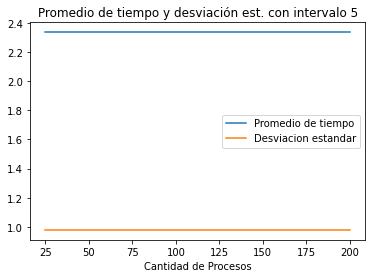

In [74]:
plt.plot([25,50,100,150,200],promedios, label = "Promedio de tiempo")
plt.plot([25,50,100,150,200],desvest, label = "Desviacion estandar")
plt.xlabel("Cantidad de Procesos")
plt.legend()
plt.title("Promedio de tiempo y desviación est. con intervalo 5")

# Simulaciones con intervalo de 1 (mucha carga de trabajo)

# 25 procesos e intervalo 1

In [75]:
# creamos una lista para guardar las horas de llegada al estado waiting de cada programa
horas_llegada = []
# creamos una lista para guardar las horas en que termina el proceso para cada programa
horas_terminado = []

In [76]:
# Creamos las variables a utilizar
RANDOM_SEED = 42
PROCESOS = 25  # Número de procesos
INTERVAL = 1  # Definido para el problema 
MEMORIA = 100 # Cpacidad de memoria de la RAM
CAPACIDAD = 1 # Capacidad de CPU 
INSTRUCCIONES_POR_TIEMPO = 3 # Instrucciones en el CPU 

In [77]:
# Definimos una clase para el proceso que al final es un programa que entra al sistema
class Programa:
    def __init__(self, env, nombre, memoria, instrucciones):
        self.env = env
        self.memoria = memoria
        self.nombre = nombre
        self.instrucciones = instrucciones
        self.estado = 'new'
        self.tiempo_espera = 0
        self.tiempo_cpu = 0
    

# Definimos los procesos tanto sus instrucciones como el espacio de memoria que se generara
def procesador(env, memoria_ram):
    while True:
        for i in range(PROCESOS):
            # damos un tiempo random antes de llegar al cpu 
            yield env.timeout(random.expovariate(1/INTERVAL)) #Para retonar consecutivamente valores
            # generamos el espacio en la memoria  ram que tomará el proceso
            memoria = random.randint(1,10)
            nombre = i
            # generamos la cantidad de instrucciones totales a realizar por el process 
            instrucciones = random.randint(1,10)
            print('El proceso %g tiene un espacio de memoria de %f y tiene %d instrucciones'%(nombre, memoria,instrucciones))
            # Iniciamos a generar procesos
            proceso = Programa(env, nombre, memoria, instrucciones)
            env.process(ingreso(env, proceso, memoria_ram))

# Se ingresa el proceso al sistema de new, ready y el paso al CPU
def ingreso(env, process, memoria_ram):
    # El proceso inicia como nuevo
    
    print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
    with memoria_ram.get(process.memoria):
        yield memoria_ram.get(process.memoria)
        process.estado = 'ready'
        process.estado = 'new'
        
        # Cuando el proceso es nuevo pasa al estado ready para colocarse en el CPU
        print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
        env.process(cpu_proceso(env, process))
    # Si el proceso termina satisfactoriamente en el cpu el estado es terminado y se devulve la memoria
    memoria_ram.put(process.memoria)
    process.estado = 'terminated'

# Se define el funcionamiento del proceso del CPU
def cpu_proceso(env, process):
    with cpu.request() as req:
        hora_llegada = env.now
        horas_llegada.append(hora_llegada)
        yield req
        # Si el proceso pasa el CPU cambia de estado a running
        process.estado = 'running'
        print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g'%(env.now))
        while process.instrucciones > 0:
            # Solo se pueden ejecutar 3 instrucciones por tiempo
            yield env.timeout(1)
            process.instrucciones -= INSTRUCCIONES_POR_TIEMPO
            process.tiempo_cpu += 1
            if process.instrucciones <= 0:
                break
            if process.tiempo_cpu % 3 == 0:
                # El proceso al terminarse puede ir a waiting o procesos de I/O según el número generado al azar
                if random.randint(1, 2) == 1:
                    process.estado = 'waiting'
                    print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
                    env.process(io_proceso(env, process))
                    yield env.timeout(1)
                    process.tiempo_espera += 1
                else:
                    process.estado = 'ready'
                    print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
                    env.process(cpu_proceso(env, process))
        process.estado = 'terminated'
        print('El proceso %g termino con exito '%(process.nombre) + ' a las %g'%(env.now))
        hora_terminado = env.now
        horas_terminado.append(hora_terminado)
        
        
# Definimos el procedimiento para las operaciones de I/O
def io_proceso(env, process):
    # El proceso entra en las operaciones I/O y al finalizar pasa a estado ready
    print('El proceso %g entro a los procesos I/O '%(process.nombre)+' a las %g'%(env.now))
    yield env.timeout(random.randint(1, 2))
    process.estado = 'ready'
    print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
    env.process(cpu_proceso(env, process))

In [78]:
# creamos el ambiente 
env = simpy.Environment()
random.seed(RANDOM_SEED)
cpu = simpy.Resource(env, capacity = CAPACIDAD)
memoria_ram = simpy.Container(env, init = MEMORIA , capacity= MEMORIA)
env.process(procesador(env, memoria_ram )) 
# nota: quite el procesos
env.run(until= 500)

El proceso 0 tiene un espacio de memoria de 1.000000 y tiene 5 instrucciones
El estado del proceso 0 es new a las 1.02006 
El estado del proceso 0 es new a las 1.02006 
El estado del proceso 0 es running a las 1.02006
El proceso 1 tiene un espacio de memoria de 3.000000 y tiene 2 instrucciones
El estado del proceso 1 es new a las 1.30095 
El estado del proceso 1 es new a las 1.30095 
El proceso 2 tiene un espacio de memoria de 9.000000 y tiene 2 instrucciones
El estado del proceso 2 es new a las 2.43013 
El estado del proceso 2 es new a las 2.43013 
El proceso 0 termino con exito  a las 3.02006
El estado del proceso 1 es running a las 3.02006
El proceso 3 tiene un espacio de memoria de 1.000000 y tiene 1 instrucciones
El estado del proceso 3 es new a las 3.32293 
El estado del proceso 3 es new a las 3.32293 
El proceso 4 tiene un espacio de memoria de 4.000000 y tiene 9 instrucciones
El estado del proceso 4 es new a las 3.42131 
El estado del proceso 4 es new a las 3.42131 
El proceso 

In [79]:
# restamos las horas de terminacion de los procesos con las horas de inicio
tiempos = []

for item1, item2 in zip(horas_terminado, horas_llegada):
    tiempos.append(item1-item2)

In [80]:
# creamos un DataFrame en el cual guardaremos los tiempos de las simulaciones
dataframe = pd.DataFrame()

In [81]:
# guardamos los tiempos de la simulacion en la columna respectiva del dataframe
dataframe["25 procesos"] = tiempos

# 50 procesos e intervalo 1

In [82]:
# creamos una lista para guardar las horas de llegada al estado waiting de cada programa
horas_llegada = []
# creamos una lista para guardar las horas en que termina el proceso para cada programa
horas_terminado = []

In [83]:
# Creamos las variables a utilizar
RANDOM_SEED = 42
PROCESOS = 50  # Número de procesos
INTERVAL = 1  # Definido para el problema 
MEMORIA = 100 # Cpacidad de memoria de la RAM
CAPACIDAD = 1 # Capacidad de CPU 
INSTRUCCIONES_POR_TIEMPO = 3 # Instrucciones en el CPU 

In [84]:
# Definimos una clase para el proceso que al final es un programa que entra al sistema
class Programa:
    def __init__(self, env, nombre, memoria, instrucciones):
        self.env = env
        self.memoria = memoria
        self.nombre = nombre
        self.instrucciones = instrucciones
        self.estado = 'new'
        self.tiempo_espera = 0
        self.tiempo_cpu = 0
    

# Definimos los procesos tanto sus instrucciones como el espacio de memoria que se generara
def procesador(env, memoria_ram):
    while True:
        for i in range(PROCESOS):
            # damos un tiempo random antes de llegar al cpu 
            yield env.timeout(random.expovariate(1/INTERVAL)) #Para retonar consecutivamente valores
            # generamos el espacio en la memoria  ram que tomará el proceso
            memoria = random.randint(1,10)
            nombre = i
            # generamos la cantidad de instrucciones totales a realizar por el process 
            instrucciones = random.randint(1,10)
            print('El proceso %g tiene un espacio de memoria de %f y tiene %d instrucciones'%(nombre, memoria,instrucciones))
            # Iniciamos a generar procesos
            proceso = Programa(env, nombre, memoria, instrucciones)
            env.process(ingreso(env, proceso, memoria_ram))

# Se ingresa el proceso al sistema de new, ready y el paso al CPU
def ingreso(env, process, memoria_ram):
    # El proceso inicia como nuevo
    
    print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
    with memoria_ram.get(process.memoria):
        yield memoria_ram.get(process.memoria)
        process.estado = 'ready'
        process.estado = 'new'
        
        # Cuando el proceso es nuevo pasa al estado ready para colocarse en el CPU
        print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
        env.process(cpu_proceso(env, process))
    # Si el proceso termina satisfactoriamente en el cpu el estado es terminado y se devulve la memoria
    memoria_ram.put(process.memoria)
    process.estado = 'terminated'

# Se define el funcionamiento del proceso del CPU
def cpu_proceso(env, process):
    with cpu.request() as req:
        hora_llegada = env.now
        horas_llegada.append(hora_llegada)
        yield req
        # Si el proceso pasa el CPU cambia de estado a running
        process.estado = 'running'
        print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g'%(env.now))
        while process.instrucciones > 0:
            # Solo se pueden ejecutar 3 instrucciones por tiempo
            yield env.timeout(1)
            process.instrucciones -= INSTRUCCIONES_POR_TIEMPO
            process.tiempo_cpu += 1
            if process.instrucciones <= 0:
                break
            if process.tiempo_cpu % 3 == 0:
                # El proceso al terminarse puede ir a waiting o procesos de I/O según el número generado al azar
                if random.randint(1, 2) == 1:
                    process.estado = 'waiting'
                    print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
                    env.process(io_proceso(env, process))
                    yield env.timeout(1)
                    process.tiempo_espera += 1
                else:
                    process.estado = 'ready'
                    print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
                    env.process(cpu_proceso(env, process))
        process.estado = 'terminated'
        print('El proceso %g termino con exito '%(process.nombre) + ' a las %g'%(env.now))
        hora_terminado = env.now
        horas_terminado.append(hora_terminado)
        
        
# Definimos el procedimiento para las operaciones de I/O
def io_proceso(env, process):
    # El proceso entra en las operaciones I/O y al finalizar pasa a estado ready
    print('El proceso %g entro a los procesos I/O '%(process.nombre)+' a las %g'%(env.now))
    yield env.timeout(random.randint(1, 2))
    process.estado = 'ready'
    print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
    env.process(cpu_proceso(env, process))

In [85]:
# creamos el ambiente 
env = simpy.Environment()
random.seed(RANDOM_SEED)
cpu = simpy.Resource(env, capacity = CAPACIDAD)
memoria_ram = simpy.Container(env, init = MEMORIA , capacity= MEMORIA)
env.process(procesador(env, memoria_ram )) 
# nota: quite el procesos
env.run(until= 500)

El proceso 0 tiene un espacio de memoria de 1.000000 y tiene 5 instrucciones
El estado del proceso 0 es new a las 1.02006 
El estado del proceso 0 es new a las 1.02006 
El estado del proceso 0 es running a las 1.02006
El proceso 1 tiene un espacio de memoria de 3.000000 y tiene 2 instrucciones
El estado del proceso 1 es new a las 1.30095 
El estado del proceso 1 es new a las 1.30095 
El proceso 2 tiene un espacio de memoria de 9.000000 y tiene 2 instrucciones
El estado del proceso 2 es new a las 2.43013 
El estado del proceso 2 es new a las 2.43013 
El proceso 0 termino con exito  a las 3.02006
El estado del proceso 1 es running a las 3.02006
El proceso 3 tiene un espacio de memoria de 1.000000 y tiene 1 instrucciones
El estado del proceso 3 es new a las 3.32293 
El estado del proceso 3 es new a las 3.32293 
El proceso 4 tiene un espacio de memoria de 4.000000 y tiene 9 instrucciones
El estado del proceso 4 es new a las 3.42131 
El estado del proceso 4 es new a las 3.42131 
El proceso 

In [86]:
# restamos las horas de terminacion de los procesos con las horas de inicio
tiempos = []

for item1, item2 in zip(horas_terminado, horas_llegada):
    tiempos.append(item1-item2)

In [87]:
# guardamos los tiempos de la simulacion en la columna respectiva del dataframe
dataframe["50 procesos"] = tiempos

# 100 procesos e intervalo 1

In [88]:
# creamos una lista para guardar las horas de llegada al estado waiting de cada programa
horas_llegada = []
# creamos una lista para guardar las horas en que termina el proceso para cada programa
horas_terminado = []

In [89]:
# Creamos las variables a utilizar
RANDOM_SEED = 42
PROCESOS = 100  # Número de procesos
INTERVAL = 1  # Definido para el problema 
MEMORIA = 100 # Cpacidad de memoria de la RAM
CAPACIDAD = 1 # Capacidad de CPU 
INSTRUCCIONES_POR_TIEMPO = 3 # Instrucciones en el CPU

In [90]:
# Definimos una clase para el proceso que al final es un programa que entra al sistema
class Programa:
    def __init__(self, env, nombre, memoria, instrucciones):
        self.env = env
        self.memoria = memoria
        self.nombre = nombre
        self.instrucciones = instrucciones
        self.estado = 'new'
        self.tiempo_espera = 0
        self.tiempo_cpu = 0
    

# Definimos los procesos tanto sus instrucciones como el espacio de memoria que se generara
def procesador(env, memoria_ram):
    while True:
        for i in range(PROCESOS):
            # damos un tiempo random antes de llegar al cpu 
            yield env.timeout(random.expovariate(1/INTERVAL)) #Para retonar consecutivamente valores
            # generamos el espacio en la memoria  ram que tomará el proceso
            memoria = random.randint(1,10)
            nombre = i
            # generamos la cantidad de instrucciones totales a realizar por el process 
            instrucciones = random.randint(1,10)
            print('El proceso %g tiene un espacio de memoria de %f y tiene %d instrucciones'%(nombre, memoria,instrucciones))
            # Iniciamos a generar procesos
            proceso = Programa(env, nombre, memoria, instrucciones)
            env.process(ingreso(env, proceso, memoria_ram))

# Se ingresa el proceso al sistema de new, ready y el paso al CPU
def ingreso(env, process, memoria_ram):
    # El proceso inicia como nuevo
    
    print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
    with memoria_ram.get(process.memoria):
        yield memoria_ram.get(process.memoria)
        process.estado = 'ready'
        process.estado = 'new'
        
        # Cuando el proceso es nuevo pasa al estado ready para colocarse en el CPU
        print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
        env.process(cpu_proceso(env, process))
    # Si el proceso termina satisfactoriamente en el cpu el estado es terminado y se devulve la memoria
    memoria_ram.put(process.memoria)
    process.estado = 'terminated'

# Se define el funcionamiento del proceso del CPU
def cpu_proceso(env, process):
    with cpu.request() as req:
        hora_llegada = env.now
        horas_llegada.append(hora_llegada)
        yield req
        # Si el proceso pasa el CPU cambia de estado a running
        process.estado = 'running'
        print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g'%(env.now))
        while process.instrucciones > 0:
            # Solo se pueden ejecutar 3 instrucciones por tiempo
            yield env.timeout(1)
            process.instrucciones -= INSTRUCCIONES_POR_TIEMPO
            process.tiempo_cpu += 1
            if process.instrucciones <= 0:
                break
            if process.tiempo_cpu % 3 == 0:
                # El proceso al terminarse puede ir a waiting o procesos de I/O según el número generado al azar
                if random.randint(1, 2) == 1:
                    process.estado = 'waiting'
                    print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
                    env.process(io_proceso(env, process))
                    yield env.timeout(1)
                    process.tiempo_espera += 1
                else:
                    process.estado = 'ready'
                    print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
                    env.process(cpu_proceso(env, process))
        process.estado = 'terminated'
        print('El proceso %g termino con exito '%(process.nombre) + ' a las %g'%(env.now))
        hora_terminado = env.now
        horas_terminado.append(hora_terminado)
        
        
# Definimos el procedimiento para las operaciones de I/O
def io_proceso(env, process):
    # El proceso entra en las operaciones I/O y al finalizar pasa a estado ready
    print('El proceso %g entro a los procesos I/O '%(process.nombre)+' a las %g'%(env.now))
    yield env.timeout(random.randint(1, 2))
    process.estado = 'ready'
    print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
    env.process(cpu_proceso(env, process))

In [91]:
# creamos el ambiente 
env = simpy.Environment()
random.seed(RANDOM_SEED)
cpu = simpy.Resource(env, capacity = CAPACIDAD)
memoria_ram = simpy.Container(env, init = MEMORIA , capacity= MEMORIA)
env.process(procesador(env, memoria_ram )) 
# nota: quite el procesos
env.run(until= 500)

El proceso 0 tiene un espacio de memoria de 1.000000 y tiene 5 instrucciones
El estado del proceso 0 es new a las 1.02006 
El estado del proceso 0 es new a las 1.02006 
El estado del proceso 0 es running a las 1.02006
El proceso 1 tiene un espacio de memoria de 3.000000 y tiene 2 instrucciones
El estado del proceso 1 es new a las 1.30095 
El estado del proceso 1 es new a las 1.30095 
El proceso 2 tiene un espacio de memoria de 9.000000 y tiene 2 instrucciones
El estado del proceso 2 es new a las 2.43013 
El estado del proceso 2 es new a las 2.43013 
El proceso 0 termino con exito  a las 3.02006
El estado del proceso 1 es running a las 3.02006
El proceso 3 tiene un espacio de memoria de 1.000000 y tiene 1 instrucciones
El estado del proceso 3 es new a las 3.32293 
El estado del proceso 3 es new a las 3.32293 
El proceso 4 tiene un espacio de memoria de 4.000000 y tiene 9 instrucciones
El estado del proceso 4 es new a las 3.42131 
El estado del proceso 4 es new a las 3.42131 
El proceso 

In [92]:
# restamos las horas de terminacion de los procesos con las horas de inicio
tiempos = []

for item1, item2 in zip(horas_terminado, horas_llegada):
    tiempos.append(item1-item2)

In [93]:
# guardamos los tiempos de la simulacion en la columna respectiva del dataframe
dataframe["100 procesos"] = tiempos

# 150 Procesos e intervalo 1

In [94]:
# creamos una lista para guardar las horas de llegada al estado waiting de cada programa
horas_llegada = []
# creamos una lista para guardar las horas en que termina el proceso para cada programa
horas_terminado = []

In [95]:
# Creamos las variables a utilizar
RANDOM_SEED = 42
PROCESOS = 150  # Número de procesos
INTERVAL = 1  # Definido para el problema 
MEMORIA = 100 # Cpacidad de memoria de la RAM
CAPACIDAD = 1 # Capacidad de CPU 
INSTRUCCIONES_POR_TIEMPO = 3 # Instrucciones en el CPU 

In [96]:
# Definimos una clase para el proceso que al final es un programa que entra al sistema
class Programa:
    def __init__(self, env, nombre, memoria, instrucciones):
        self.env = env
        self.memoria = memoria
        self.nombre = nombre
        self.instrucciones = instrucciones
        self.estado = 'new'
        self.tiempo_espera = 0
        self.tiempo_cpu = 0
    

# Definimos los procesos tanto sus instrucciones como el espacio de memoria que se generara
def procesador(env, memoria_ram):
    while True:
        for i in range(PROCESOS):
            # damos un tiempo random antes de llegar al cpu 
            yield env.timeout(random.expovariate(1/INTERVAL)) #Para retonar consecutivamente valores
            # generamos el espacio en la memoria  ram que tomará el proceso
            memoria = random.randint(1,10)
            nombre = i
            # generamos la cantidad de instrucciones totales a realizar por el process 
            instrucciones = random.randint(1,10)
            print('El proceso %g tiene un espacio de memoria de %f y tiene %d instrucciones'%(nombre, memoria,instrucciones))
            # Iniciamos a generar procesos
            proceso = Programa(env, nombre, memoria, instrucciones)
            env.process(ingreso(env, proceso, memoria_ram))

# Se ingresa el proceso al sistema de new, ready y el paso al CPU
def ingreso(env, process, memoria_ram):
    # El proceso inicia como nuevo
    
    print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
    with memoria_ram.get(process.memoria):
        yield memoria_ram.get(process.memoria)
        process.estado = 'ready'
        process.estado = 'new'
        
        # Cuando el proceso es nuevo pasa al estado ready para colocarse en el CPU
        print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
        env.process(cpu_proceso(env, process))
    # Si el proceso termina satisfactoriamente en el cpu el estado es terminado y se devulve la memoria
    memoria_ram.put(process.memoria)
    process.estado = 'terminated'

# Se define el funcionamiento del proceso del CPU
def cpu_proceso(env, process):
    with cpu.request() as req:
        hora_llegada = env.now
        horas_llegada.append(hora_llegada)
        yield req
        # Si el proceso pasa el CPU cambia de estado a running
        process.estado = 'running'
        print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g'%(env.now))
        while process.instrucciones > 0:
            # Solo se pueden ejecutar 3 instrucciones por tiempo
            yield env.timeout(1)
            process.instrucciones -= INSTRUCCIONES_POR_TIEMPO
            process.tiempo_cpu += 1
            if process.instrucciones <= 0:
                break
            if process.tiempo_cpu % 3 == 0:
                # El proceso al terminarse puede ir a waiting o procesos de I/O según el número generado al azar
                if random.randint(1, 2) == 1:
                    process.estado = 'waiting'
                    print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
                    env.process(io_proceso(env, process))
                    yield env.timeout(1)
                    process.tiempo_espera += 1
                else:
                    process.estado = 'ready'
                    print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
                    env.process(cpu_proceso(env, process))
        process.estado = 'terminated'
        print('El proceso %g termino con exito '%(process.nombre) + ' a las %g'%(env.now))
        hora_terminado = env.now
        horas_terminado.append(hora_terminado)
        
        
# Definimos el procedimiento para las operaciones de I/O
def io_proceso(env, process):
    # El proceso entra en las operaciones I/O y al finalizar pasa a estado ready
    print('El proceso %g entro a los procesos I/O '%(process.nombre)+' a las %g'%(env.now))
    yield env.timeout(random.randint(1, 2))
    process.estado = 'ready'
    print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
    env.process(cpu_proceso(env, process))

In [97]:
# creamos el ambiente 
env = simpy.Environment()
random.seed(RANDOM_SEED)
cpu = simpy.Resource(env, capacity = CAPACIDAD)
memoria_ram = simpy.Container(env, init = MEMORIA , capacity= MEMORIA)
env.process(procesador(env, memoria_ram )) 
# nota: quite el procesos
env.run(until= 500)

El proceso 0 tiene un espacio de memoria de 1.000000 y tiene 5 instrucciones
El estado del proceso 0 es new a las 1.02006 
El estado del proceso 0 es new a las 1.02006 
El estado del proceso 0 es running a las 1.02006
El proceso 1 tiene un espacio de memoria de 3.000000 y tiene 2 instrucciones
El estado del proceso 1 es new a las 1.30095 
El estado del proceso 1 es new a las 1.30095 
El proceso 2 tiene un espacio de memoria de 9.000000 y tiene 2 instrucciones
El estado del proceso 2 es new a las 2.43013 
El estado del proceso 2 es new a las 2.43013 
El proceso 0 termino con exito  a las 3.02006
El estado del proceso 1 es running a las 3.02006
El proceso 3 tiene un espacio de memoria de 1.000000 y tiene 1 instrucciones
El estado del proceso 3 es new a las 3.32293 
El estado del proceso 3 es new a las 3.32293 
El proceso 4 tiene un espacio de memoria de 4.000000 y tiene 9 instrucciones
El estado del proceso 4 es new a las 3.42131 
El estado del proceso 4 es new a las 3.42131 
El proceso 

In [98]:
# restamos las horas de terminacion de los procesos con las horas de inicio
tiempos = []

for item1, item2 in zip(horas_terminado, horas_llegada):
    tiempos.append(item1-item2)

In [99]:
# guardamos los tiempos de la simulacion en la columna respectiva del dataframe
dataframe["150 procesos"] = tiempos

# 200 procesos e intervalo 1

In [100]:
# creamos una lista para guardar las horas de llegada al estado waiting de cada programa
horas_llegada = []
# creamos una lista para guardar las horas en que termina el proceso para cada programa
horas_terminado = []

In [101]:
# Creamos las variables a utilizar
RANDOM_SEED = 42
PROCESOS = 200  # Número de procesos
INTERVAL = 1  # Definido para el problema 
MEMORIA = 100 # Cpacidad de memoria de la RAM
CAPACIDAD = 1 # Capacidad de CPU 
INSTRUCCIONES_POR_TIEMPO = 3 # Instrucciones en el CPU

In [102]:
# Definimos una clase para el proceso que al final es un programa que entra al sistema
class Programa:
    def __init__(self, env, nombre, memoria, instrucciones):
        self.env = env
        self.memoria = memoria
        self.nombre = nombre
        self.instrucciones = instrucciones
        self.estado = 'new'
        self.tiempo_espera = 0
        self.tiempo_cpu = 0
    

# Definimos los procesos tanto sus instrucciones como el espacio de memoria que se generara
def procesador(env, memoria_ram):
    while True:
        for i in range(PROCESOS):
            # damos un tiempo random antes de llegar al cpu 
            yield env.timeout(random.expovariate(1/INTERVAL)) #Para retonar consecutivamente valores
            # generamos el espacio en la memoria  ram que tomará el proceso
            memoria = random.randint(1,10)
            nombre = i
            # generamos la cantidad de instrucciones totales a realizar por el process 
            instrucciones = random.randint(1,10)
            print('El proceso %g tiene un espacio de memoria de %f y tiene %d instrucciones'%(nombre, memoria,instrucciones))
            # Iniciamos a generar procesos
            proceso = Programa(env, nombre, memoria, instrucciones)
            env.process(ingreso(env, proceso, memoria_ram))

# Se ingresa el proceso al sistema de new, ready y el paso al CPU
def ingreso(env, process, memoria_ram):
    # El proceso inicia como nuevo
    
    print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
    with memoria_ram.get(process.memoria):
        yield memoria_ram.get(process.memoria)
        process.estado = 'ready'
        process.estado = 'new'
        
        # Cuando el proceso es nuevo pasa al estado ready para colocarse en el CPU
        print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
        env.process(cpu_proceso(env, process))
    # Si el proceso termina satisfactoriamente en el cpu el estado es terminado y se devulve la memoria
    memoria_ram.put(process.memoria)
    process.estado = 'terminated'

# Se define el funcionamiento del proceso del CPU
def cpu_proceso(env, process):
    with cpu.request() as req:
        hora_llegada = env.now
        horas_llegada.append(hora_llegada)
        yield req
        # Si el proceso pasa el CPU cambia de estado a running
        process.estado = 'running'
        print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g'%(env.now))
        while process.instrucciones > 0:
            # Solo se pueden ejecutar 3 instrucciones por tiempo
            yield env.timeout(1)
            process.instrucciones -= INSTRUCCIONES_POR_TIEMPO
            process.tiempo_cpu += 1
            if process.instrucciones <= 0:
                break
            if process.tiempo_cpu % 3 == 0:
                # El proceso al terminarse puede ir a waiting o procesos de I/O según el número generado al azar
                if random.randint(1, 2) == 1:
                    process.estado = 'waiting'
                    print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
                    env.process(io_proceso(env, process))
                    yield env.timeout(1)
                    process.tiempo_espera += 1
                else:
                    process.estado = 'ready'
                    print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
                    env.process(cpu_proceso(env, process))
        process.estado = 'terminated'
        print('El proceso %g termino con exito '%(process.nombre) + ' a las %g'%(env.now))
        hora_terminado = env.now
        horas_terminado.append(hora_terminado)
        
        
# Definimos el procedimiento para las operaciones de I/O
def io_proceso(env, process):
    # El proceso entra en las operaciones I/O y al finalizar pasa a estado ready
    print('El proceso %g entro a los procesos I/O '%(process.nombre)+' a las %g'%(env.now))
    yield env.timeout(random.randint(1, 2))
    process.estado = 'ready'
    print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
    env.process(cpu_proceso(env, process))

In [103]:
# creamos el ambiente 
env = simpy.Environment()
random.seed(RANDOM_SEED)
cpu = simpy.Resource(env, capacity = CAPACIDAD)
memoria_ram = simpy.Container(env, init = MEMORIA , capacity= MEMORIA)
env.process(procesador(env, memoria_ram )) 
# nota: quite el procesos
env.run(until= 500)

El proceso 0 tiene un espacio de memoria de 1.000000 y tiene 5 instrucciones
El estado del proceso 0 es new a las 1.02006 
El estado del proceso 0 es new a las 1.02006 
El estado del proceso 0 es running a las 1.02006
El proceso 1 tiene un espacio de memoria de 3.000000 y tiene 2 instrucciones
El estado del proceso 1 es new a las 1.30095 
El estado del proceso 1 es new a las 1.30095 
El proceso 2 tiene un espacio de memoria de 9.000000 y tiene 2 instrucciones
El estado del proceso 2 es new a las 2.43013 
El estado del proceso 2 es new a las 2.43013 
El proceso 0 termino con exito  a las 3.02006
El estado del proceso 1 es running a las 3.02006
El proceso 3 tiene un espacio de memoria de 1.000000 y tiene 1 instrucciones
El estado del proceso 3 es new a las 3.32293 
El estado del proceso 3 es new a las 3.32293 
El proceso 4 tiene un espacio de memoria de 4.000000 y tiene 9 instrucciones
El estado del proceso 4 es new a las 3.42131 
El estado del proceso 4 es new a las 3.42131 
El proceso 

In [104]:
# restamos las horas de terminacion de los procesos con las horas de inicio
tiempos = []

for item1, item2 in zip(horas_terminado, horas_llegada):
    tiempos.append(item1-item2)

In [105]:
# guardamos los tiempos de la simulacion en la columna respectiva del dataframe
dataframe["200 procesos"] = tiempos

# Gráficos de media y desviación estándar

In [106]:
# creamos una lista con los promedios 
promedios = []

# calculamos los promedios de cada columna del dataframe
for column in dataframe:
    promedios.append(dataframe[column].mean())

In [107]:
# creamos una lista para guardar las desviaciones estandar
desvest = []

# calculamos los promedios de cada columna del dataframe
for column in dataframe:
    desvest.append(dataframe[column].std())

Text(0.5, 1.0, 'Promedio de tiempo y desviación est. con intervalo 1')

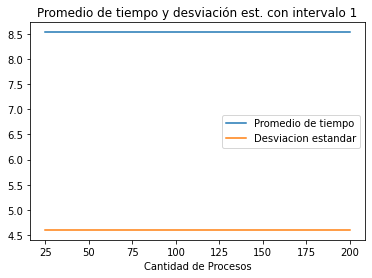

In [108]:
plt.plot([25,50,100,150,200],promedios, label = "Promedio de tiempo")
plt.plot([25,50,100,150,200],desvest, label = "Desviacion estandar")
plt.xlabel("Cantidad de Procesos")
plt.legend()
plt.title("Promedio de tiempo y desviación est. con intervalo 1")

# Incrementando la memoria a 200
## 100 procesos, intervalo 10 y memoria 200

In [109]:
# creamos una lista para guardar las horas de llegada al estado waiting de cada programa
horas_llegada = []
# creamos una lista para guardar las horas en que termina el proceso para cada programa
horas_terminado = []

In [110]:
# Creamos las variables a utilizar
RANDOM_SEED = 42
PROCESOS = 100  # Número de procesos
INTERVAL = 10  # Definido para el problema 
MEMORIA = 200 # Cpacidad de memoria de la RAM
CAPACIDAD = 1 # Capacidad de CPU 
INSTRUCCIONES_POR_TIEMPO = 3 # Instrucciones en el CPU

In [111]:
# Definimos una clase para el proceso que al final es un programa que entra al sistema
class Programa:
    def __init__(self, env, nombre, memoria, instrucciones):
        self.env = env
        self.memoria = memoria
        self.nombre = nombre
        self.instrucciones = instrucciones
        self.estado = 'new'
        self.tiempo_espera = 0
        self.tiempo_cpu = 0
    

# Definimos los procesos tanto sus instrucciones como el espacio de memoria que se generara
def procesador(env, memoria_ram):
    while True:
        for i in range(PROCESOS):
            # damos un tiempo random antes de llegar al cpu 
            yield env.timeout(random.expovariate(1/INTERVAL)) #Para retonar consecutivamente valores
            # generamos el espacio en la memoria  ram que tomará el proceso
            memoria = random.randint(1,10)
            nombre = i
            # generamos la cantidad de instrucciones totales a realizar por el process 
            instrucciones = random.randint(1,10)
            print('El proceso %g tiene un espacio de memoria de %f y tiene %d instrucciones'%(nombre, memoria,instrucciones))
            # Iniciamos a generar procesos
            proceso = Programa(env, nombre, memoria, instrucciones)
            env.process(ingreso(env, proceso, memoria_ram))

# Se ingresa el proceso al sistema de new, ready y el paso al CPU
def ingreso(env, process, memoria_ram):
    # El proceso inicia como nuevo
    
    print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
    with memoria_ram.get(process.memoria):
        yield memoria_ram.get(process.memoria)
        process.estado = 'ready'
        process.estado = 'new'
        
        # Cuando el proceso es nuevo pasa al estado ready para colocarse en el CPU
        print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
        env.process(cpu_proceso(env, process))
    # Si el proceso termina satisfactoriamente en el cpu el estado es terminado y se devulve la memoria
    memoria_ram.put(process.memoria)
    process.estado = 'terminated'

# Se define el funcionamiento del proceso del CPU
def cpu_proceso(env, process):
    with cpu.request() as req:
        hora_llegada = env.now
        horas_llegada.append(hora_llegada)
        yield req
        # Si el proceso pasa el CPU cambia de estado a running
        process.estado = 'running'
        print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g'%(env.now))
        while process.instrucciones > 0:
            # Solo se pueden ejecutar 3 instrucciones por tiempo
            yield env.timeout(1)
            process.instrucciones -= INSTRUCCIONES_POR_TIEMPO
            process.tiempo_cpu += 1
            if process.instrucciones <= 0:
                break
            if process.tiempo_cpu % 3 == 0:
                # El proceso al terminarse puede ir a waiting o procesos de I/O según el número generado al azar
                if random.randint(1, 2) == 1:
                    process.estado = 'waiting'
                    print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
                    env.process(io_proceso(env, process))
                    yield env.timeout(1)
                    process.tiempo_espera += 1
                else:
                    process.estado = 'ready'
                    print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
                    env.process(cpu_proceso(env, process))
        process.estado = 'terminated'
        print('El proceso %g termino con exito '%(process.nombre) + ' a las %g'%(env.now))
        hora_terminado = env.now
        horas_terminado.append(hora_terminado)
        
        
# Definimos el procedimiento para las operaciones de I/O
def io_proceso(env, process):
    # El proceso entra en las operaciones I/O y al finalizar pasa a estado ready
    print('El proceso %g entro a los procesos I/O '%(process.nombre)+' a las %g'%(env.now))
    yield env.timeout(random.randint(1, 2))
    process.estado = 'ready'
    print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
    env.process(cpu_proceso(env, process))

In [112]:
# creamos el ambiente 
env = simpy.Environment()
random.seed(RANDOM_SEED)
cpu = simpy.Resource(env, capacity = CAPACIDAD)
memoria_ram = simpy.Container(env, init = MEMORIA , capacity= MEMORIA)
env.process(procesador(env, memoria_ram )) 
# nota: quite el procesos
env.run(until= 500)

El proceso 0 tiene un espacio de memoria de 1.000000 y tiene 5 instrucciones
El estado del proceso 0 es new a las 10.2006 
El estado del proceso 0 es new a las 10.2006 
El estado del proceso 0 es running a las 10.2006
El proceso 0 termino con exito  a las 12.2006
El proceso 1 tiene un espacio de memoria de 3.000000 y tiene 2 instrucciones
El estado del proceso 1 es new a las 13.0095 
El estado del proceso 1 es new a las 13.0095 
El estado del proceso 1 es running a las 13.0095
El proceso 1 termino con exito  a las 14.0095
El proceso 2 tiene un espacio de memoria de 9.000000 y tiene 2 instrucciones
El estado del proceso 2 es new a las 24.3013 
El estado del proceso 2 es new a las 24.3013 
El estado del proceso 2 es running a las 24.3013
El proceso 2 termino con exito  a las 25.3013
El proceso 3 tiene un espacio de memoria de 1.000000 y tiene 1 instrucciones
El estado del proceso 3 es new a las 33.2293 
El estado del proceso 3 es new a las 33.2293 
El estado del proceso 3 es running a la

In [113]:
# restamos las horas de terminacion de los procesos con las horas de inicio
tiempos = []

for item1, item2 in zip(horas_terminado, horas_llegada):
    tiempos.append(item1-item2)

In [114]:
tiempos

[2.0,
 1.0,
 1.0,
 1.0,
 3.01620350341544,
 2.0,
 3.0,
 2.5097358103317617,
 1.0,
 2.0,
 1.310137319127307,
 2.336810805727737,
 2.0,
 3.0,
 2.666672586679084,
 2.0,
 1.0,
 1.0,
 3.0,
 1.0,
 2.0,
 5.0,
 1.0,
 3.0,
 2.0,
 2.0,
 3.0,
 4.0,
 1.0,
 3.0,
 1.0,
 3.0,
 3.0,
 2.0,
 3.0,
 1.0,
 3.0,
 3.0]

In [115]:
len(tiempos)

38

In [116]:
# creamos un dataframe para guardar los tiempos
df1 = pd.DataFrame()
# guardamos los tiempos en el dataframe
df1["1 col"] = tiempos

In [117]:
# creamos una lista para guardar las medias
listamedias = []
# guardamos la media de los tiempos de la simulacion en la lista
listamedias.append(df1["1 col"].mean())

In [118]:
df1["1 col"].mean()

2.1799884217179297

# Procesador más rápido -6 instrucciones por unidad de tiempo-.
## 100 procesos, intervalo 10 y 6 instrucciones por unidad de tiempo

In [119]:
# creamos una lista para guardar las horas de llegada al estado waiting de cada programa
horas_llegada = []
# creamos una lista para guardar las horas en que termina el proceso para cada programa
horas_terminado = []

In [120]:
# Creamos las variables a utilizar
RANDOM_SEED = 42
PROCESOS = 100  # Número de procesos
INTERVAL = 10  # Definido para el problema 
MEMORIA = 200 # Cpacidad de memoria de la RAM
CAPACIDAD = 1 # Capacidad de CPU 
INSTRUCCIONES_POR_TIEMPO = 6 # Instrucciones en el CPU

In [121]:
# Definimos una clase para el proceso que al final es un programa que entra al sistema
class Programa:
    def __init__(self, env, nombre, memoria, instrucciones):
        self.env = env
        self.memoria = memoria
        self.nombre = nombre
        self.instrucciones = instrucciones
        self.estado = 'new'
        self.tiempo_espera = 0
        self.tiempo_cpu = 0
    

# Definimos los procesos tanto sus instrucciones como el espacio de memoria que se generara
def procesador(env, memoria_ram):
    while True:
        for i in range(PROCESOS):
            # damos un tiempo random antes de llegar al cpu 
            yield env.timeout(random.expovariate(1/INTERVAL)) #Para retonar consecutivamente valores
            # generamos el espacio en la memoria  ram que tomará el proceso
            memoria = random.randint(1,10)
            nombre = i
            # generamos la cantidad de instrucciones totales a realizar por el process 
            instrucciones = random.randint(1,10)
            print('El proceso %g tiene un espacio de memoria de %f y tiene %d instrucciones'%(nombre, memoria,instrucciones))
            # Iniciamos a generar procesos
            proceso = Programa(env, nombre, memoria, instrucciones)
            env.process(ingreso(env, proceso, memoria_ram))

# Se ingresa el proceso al sistema de new, ready y el paso al CPU
def ingreso(env, process, memoria_ram):
    # El proceso inicia como nuevo
    
    print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
    with memoria_ram.get(process.memoria):
        yield memoria_ram.get(process.memoria)
        process.estado = 'ready'
        process.estado = 'new'
        
        # Cuando el proceso es nuevo pasa al estado ready para colocarse en el CPU
        print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
        env.process(cpu_proceso(env, process))
    # Si el proceso termina satisfactoriamente en el cpu el estado es terminado y se devulve la memoria
    memoria_ram.put(process.memoria)
    process.estado = 'terminated'

# Se define el funcionamiento del proceso del CPU
def cpu_proceso(env, process):
    with cpu.request() as req:
        hora_llegada = env.now
        horas_llegada.append(hora_llegada)
        yield req
        # Si el proceso pasa el CPU cambia de estado a running
        process.estado = 'running'
        print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g'%(env.now))
        while process.instrucciones > 0:
            # Solo se pueden ejecutar 3 instrucciones por tiempo
            yield env.timeout(1)
            process.instrucciones -= INSTRUCCIONES_POR_TIEMPO
            process.tiempo_cpu += 1
            if process.instrucciones <= 0:
                break
            if process.tiempo_cpu % 3 == 0:
                # El proceso al terminarse puede ir a waiting o procesos de I/O según el número generado al azar
                if random.randint(1, 2) == 1:
                    process.estado = 'waiting'
                    print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
                    env.process(io_proceso(env, process))
                    yield env.timeout(1)
                    process.tiempo_espera += 1
                else:
                    process.estado = 'ready'
                    print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
                    env.process(cpu_proceso(env, process))
        process.estado = 'terminated'
        print('El proceso %g termino con exito '%(process.nombre) + ' a las %g'%(env.now))
        hora_terminado = env.now
        horas_terminado.append(hora_terminado)
        
        
# Definimos el procedimiento para las operaciones de I/O
def io_proceso(env, process):
    # El proceso entra en las operaciones I/O y al finalizar pasa a estado ready
    print('El proceso %g entro a los procesos I/O '%(process.nombre)+' a las %g'%(env.now))
    yield env.timeout(random.randint(1, 2))
    process.estado = 'ready'
    print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
    env.process(cpu_proceso(env, process))

In [122]:
# creamos el ambiente 
env = simpy.Environment()
random.seed(RANDOM_SEED)
cpu = simpy.Resource(env, capacity = CAPACIDAD)
memoria_ram = simpy.Container(env, init = MEMORIA , capacity= MEMORIA)
env.process(procesador(env, memoria_ram )) 
# nota: quite el procesos
env.run(until= 500)

El proceso 0 tiene un espacio de memoria de 1.000000 y tiene 5 instrucciones
El estado del proceso 0 es new a las 10.2006 
El estado del proceso 0 es new a las 10.2006 
El estado del proceso 0 es running a las 10.2006
El proceso 0 termino con exito  a las 11.2006
El proceso 1 tiene un espacio de memoria de 3.000000 y tiene 2 instrucciones
El estado del proceso 1 es new a las 13.0095 
El estado del proceso 1 es new a las 13.0095 
El estado del proceso 1 es running a las 13.0095
El proceso 1 termino con exito  a las 14.0095
El proceso 2 tiene un espacio de memoria de 9.000000 y tiene 2 instrucciones
El estado del proceso 2 es new a las 24.3013 
El estado del proceso 2 es new a las 24.3013 
El estado del proceso 2 es running a las 24.3013
El proceso 2 termino con exito  a las 25.3013
El proceso 3 tiene un espacio de memoria de 1.000000 y tiene 1 instrucciones
El estado del proceso 3 es new a las 33.2293 
El estado del proceso 3 es new a las 33.2293 
El estado del proceso 3 es running a la

In [123]:
# restamos las horas de terminacion de los procesos con las horas de inicio
tiempos = []

for item1, item2 in zip(horas_terminado, horas_llegada):
    tiempos.append(item1-item2)

In [124]:
tiempos

[1.0,
 1.0,
 1.0,
 1.0,
 2.01620350341544,
 1.0,
 2.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.02667348660043,
 1.0,
 2.0,
 1.66667258667907,
 1.0,
 1.0,
 1.0,
 2.0,
 1.0,
 1.0,
 2.0,
 1.0,
 1.0,
 1.0,
 1.0,
 2.0,
 2.0,
 1.0,
 2.0,
 1.458324645149446,
 1.0,
 2.0,
 1.0,
 1.0,
 1.0]

In [125]:
len(tiempos)

36

In [126]:
# creamos un dataframe para guardar los tiempos
df2 = pd.DataFrame()
# guardamos los tiempos en el dataframe
df2["1 col"] = tiempos

In [127]:
df2["1 col"].mean()

1.2824409506067884

In [128]:
# guardamos la media de los tiempos de la simulacion en la lista
listamedias.append(df2["1 col"].mean())

# Dos procesadores

In [129]:
# creamos una lista para guardar las horas de llegada al estado waiting de cada programa
horas_llegada = []
# creamos una lista para guardar las horas en que termina el proceso para cada programa
horas_terminado = []

In [130]:
# Creamos las variables a utilizar
RANDOM_SEED = 42
PROCESOS = 100  # Número de procesos
INTERVAL = 10  # Definido para el problema 
MEMORIA = 200 # Cpacidad de memoria de la RAM
CAPACIDAD = 2 # Capacidad de CPU 
INSTRUCCIONES_POR_TIEMPO = 6 # Instrucciones en el CPU

In [131]:
# Definimos una clase para el proceso que al final es un programa que entra al sistema
class Programa:
    def __init__(self, env, nombre, memoria, instrucciones):
        self.env = env
        self.memoria = memoria
        self.nombre = nombre
        self.instrucciones = instrucciones
        self.estado = 'new'
        self.tiempo_espera = 0
        self.tiempo_cpu = 0
    

# Definimos los procesos tanto sus instrucciones como el espacio de memoria que se generara
def procesador(env, memoria_ram):
    while True:
        for i in range(PROCESOS):
            # damos un tiempo random antes de llegar al cpu 
            yield env.timeout(random.expovariate(1/INTERVAL)) #Para retonar consecutivamente valores
            # generamos el espacio en la memoria  ram que tomará el proceso
            memoria = random.randint(1,10)
            nombre = i
            # generamos la cantidad de instrucciones totales a realizar por el process 
            instrucciones = random.randint(1,10)
            print('El proceso %g tiene un espacio de memoria de %f y tiene %d instrucciones'%(nombre, memoria,instrucciones))
            # Iniciamos a generar procesos
            proceso = Programa(env, nombre, memoria, instrucciones)
            env.process(ingreso(env, proceso, memoria_ram))

# Se ingresa el proceso al sistema de new, ready y el paso al CPU
def ingreso(env, process, memoria_ram):
    # El proceso inicia como nuevo
    
    print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
    with memoria_ram.get(process.memoria):
        yield memoria_ram.get(process.memoria)
        process.estado = 'ready'
        process.estado = 'new'
        
        # Cuando el proceso es nuevo pasa al estado ready para colocarse en el CPU
        print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
        env.process(cpu_proceso(env, process))
    # Si el proceso termina satisfactoriamente en el cpu el estado es terminado y se devulve la memoria
    memoria_ram.put(process.memoria)
    process.estado = 'terminated'

# Se define el funcionamiento del proceso del CPU
def cpu_proceso(env, process):
    with cpu.request() as req:
        hora_llegada = env.now
        horas_llegada.append(hora_llegada)
        yield req
        # Si el proceso pasa el CPU cambia de estado a running
        process.estado = 'running'
        print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g'%(env.now))
        while process.instrucciones > 0:
            # Solo se pueden ejecutar 3 instrucciones por tiempo
            yield env.timeout(1)
            process.instrucciones -= INSTRUCCIONES_POR_TIEMPO
            process.tiempo_cpu += 1
            if process.instrucciones <= 0:
                break
            if process.tiempo_cpu % 3 == 0:
                # El proceso al terminarse puede ir a waiting o procesos de I/O según el número generado al azar
                if random.randint(1, 2) == 1:
                    process.estado = 'waiting'
                    print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
                    env.process(io_proceso(env, process))
                    yield env.timeout(1)
                    process.tiempo_espera += 1
                else:
                    process.estado = 'ready'
                    print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
                    env.process(cpu_proceso(env, process))
        process.estado = 'terminated'
        print('El proceso %g termino con exito '%(process.nombre) + ' a las %g'%(env.now))
        hora_terminado = env.now
        horas_terminado.append(hora_terminado)
        
        
# Definimos el procedimiento para las operaciones de I/O
def io_proceso(env, process):
    # El proceso entra en las operaciones I/O y al finalizar pasa a estado ready
    print('El proceso %g entro a los procesos I/O '%(process.nombre)+' a las %g'%(env.now))
    yield env.timeout(random.randint(1, 2))
    process.estado = 'ready'
    print('El estado del proceso %g es '%(process.nombre)+ process.estado + ' a las %g '%(env.now))
    env.process(cpu_proceso(env, process))

In [132]:
# creamos el ambiente 
env = simpy.Environment()
random.seed(RANDOM_SEED)
cpu = simpy.Resource(env, capacity = CAPACIDAD)
memoria_ram = simpy.Container(env, init = MEMORIA , capacity= MEMORIA)
env.process(procesador(env, memoria_ram )) 
# nota: quite el procesos
env.run(until= 500)

El proceso 0 tiene un espacio de memoria de 1.000000 y tiene 5 instrucciones
El estado del proceso 0 es new a las 10.2006 
El estado del proceso 0 es new a las 10.2006 
El estado del proceso 0 es running a las 10.2006
El proceso 0 termino con exito  a las 11.2006
El proceso 1 tiene un espacio de memoria de 3.000000 y tiene 2 instrucciones
El estado del proceso 1 es new a las 13.0095 
El estado del proceso 1 es new a las 13.0095 
El estado del proceso 1 es running a las 13.0095
El proceso 1 termino con exito  a las 14.0095
El proceso 2 tiene un espacio de memoria de 9.000000 y tiene 2 instrucciones
El estado del proceso 2 es new a las 24.3013 
El estado del proceso 2 es new a las 24.3013 
El estado del proceso 2 es running a las 24.3013
El proceso 2 termino con exito  a las 25.3013
El proceso 3 tiene un espacio de memoria de 1.000000 y tiene 1 instrucciones
El estado del proceso 3 es new a las 33.2293 
El estado del proceso 3 es new a las 33.2293 
El estado del proceso 3 es running a la

In [133]:
# restamos las horas de terminacion de los procesos con las horas de inicio
tiempos = []

for item1, item2 in zip(horas_terminado, horas_llegada):
    tiempos.append(item1-item2)

In [134]:
# creamos un dataframe para guardar los tiempos
df3 = pd.DataFrame()
# guardamos los tiempos en el dataframe
df3["1 col"] = tiempos

In [135]:
df3["1 col"].mean()

1.25

In [136]:
# guardamos la media de los tiempos de la simulacion en la lista
listamedias.append(df3["1 col"].mean())

# Comparación de tiempos

In [137]:
listamedias

[2.1799884217179297, 1.2824409506067884, 1.25]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Comparación de promedio de tiempo con 100 procesos')

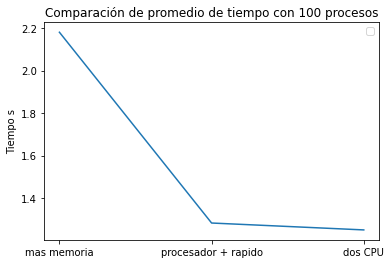

In [138]:
plt.plot(["mas memoria", "procesador + rapido","dos CPU"],listamedias)
plt.ylabel("Tiempo s")
plt.legend()
plt.title("Comparación de promedio de tiempo con 100 procesos")